In [1]:
import sys
sys.path.append("/home/belle2/amubarak/Ds2D0enue_Analysis/08-Python_Functions")

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from Ds2D0e_config import DECAY_CONFIG, BACKGROUND_SAMPLES, get_signal_file, get_generic_file

In [ ]:
pd.set_option('display.max_rows', 200000)
pd.set_option('display.max_columns', 200000)

In [ ]:
plt.rcParams.update({
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 16
})

  # Real vs Fake D⁰ sanity study

  * Load the same signal/generic samples as Phase 1 (centralized in Ds2D0e_config)
  * Apply the D⁰ mass window cuts
  * Define "real D⁰" and "fake D⁰"
    - Real D⁰: `abs(D0_mcPDG) == 421` (D⁰ and D̄⁰)
    - Fake D⁰: `abs(D0_mcPDG) != 421` or NaN
  * Correlations:
    - Full correlation matrix (D⁰ vars + fit vars)
    - Heatmaps of D⁰ vars vs each fit variable, using corr()[[fit_var]]
  * Real vs fake D⁰ distributions for all K_*, pi_*, pi0_*, D0_* variables

In [ ]:
# ========================================
# CONFIG
# ========================================
APPLY_GAMMA_VETO = False
GAMMAVETO_THRESHOLD = 0.1  # reserved for later phases

# Control sample toggle (use control-sample ROOT files)
USE_CONTROL_SAMPLE = False
CONTROL_SAMPLE_TAG = "noEID"  # options: "noEID", "wrongCharge", ["noEID", "wrongCharge"], or "all"


# Histogram settings for real vs fake comparisons
BINS_HIST = 50
DENSITY_HIST = True

COLOR_REAL = "purple"
COLOR_FAKE = "#D55E00"
LINEWIDTH = 2.5

# Fit variables
fit_vars = ["Ds_massDifference_0", "Ds_diff_D0pi"]

# Nice LaTeX titles per mode (decay chain only)
mode_titles = {
    "kmpip": r"$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} \pi^{+}] e^{+} \nu_{e}$",
    "kmpippi0_eff20_May2020": r"$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} \pi^{+} \pi^{0}] e^{+} \nu_{e}$",
    "km3pi": r"$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} 3\pi] e^{+} \nu_{e}$",
}

# For convenience, keep local aliases
decay_config = DECAY_CONFIG
background_samples = BACKGROUND_SAMPLES

# =====================================================================
# uproot performance settings
# =====================================================================
UROOT_BRANCH_FILTER = [
    "D0_*",                         # D0_mcPDG, D0_dM, D0_* kinematics etc
    "K_*",                          # K_* daughters
    "pi_*",                         # pi_* daughters (kmpip, kmpippi0)
    "pi1_*",                        # pi1_* daughters (km3pi mode)
    "pi2_*",                        # pi2_* daughters (km3pi mode)
    "pi3_*",                        # pi3_* daughters (km3pi mode)
    "pi0_*",                        # pi0_* daughters
    "Ds_massDifference_0",          # Δm_e
    "Ds_diff_D0pi",                 # Δm_π
    "Ds_isSignal",                  # truth flag, useful elsewhere
    "Ds_gammaveto_M_Correction",    # for later gamma veto phases
]

UROOT_NUM_WORKERS = 16

  ## Data loading (with D⁰ mass window cuts, branch filtered)

In [5]:
DataFrames = {}  # dictionary to hold dataframes

def _build_tree_paths(file_or_files, tree_name):
    if isinstance(file_or_files, (list, tuple, set)):
        return [f"{f}:{tree_name}" for f in file_or_files]
    return [f"{file_or_files}:{tree_name}"]

print("Loading Signal files (branch filtered)...")
for mode, config in tqdm(list(decay_config.items()), desc="Signal modes"):
    signal_file = get_signal_file(
        mode,
        use_control_sample=USE_CONTROL_SAMPLE,
        control_sample_tag=CONTROL_SAMPLE_TAG,
    )
    signal_tree_paths = _build_tree_paths(signal_file, config['ds_tree'])

    try:
        df = uproot.concatenate(
            signal_tree_paths,
            library="pd",
            filter_name=UROOT_BRANCH_FILTER,
            num_workers=UROOT_NUM_WORKERS,
        )
    except TypeError:
        # fallback if uproot version does not support num_workers
        df = uproot.concatenate(
            signal_tree_paths,
            library="pd",
            filter_name=UROOT_BRANCH_FILTER,
        )

    df = df.query(config["cut"])
    DataFrames[f"Signal_{mode}"] = df

print("\nLoading Background files (branch filtered)...")
for sample in tqdm(background_samples, desc="Background samples"):
    for mode, config in decay_config.items():
        generic_file = get_generic_file(
            sample,
            mode,
            use_control_sample=USE_CONTROL_SAMPLE,
            control_sample_tag=CONTROL_SAMPLE_TAG,
        )
        generic_tree_paths = _build_tree_paths(generic_file, config['ds_tree'])

        try:
            df = uproot.concatenate(
                generic_tree_paths,  # FIXED: was signal_tree_paths
                library="pd",
                filter_name=UROOT_BRANCH_FILTER,
                num_workers=UROOT_NUM_WORKERS,
            )
        except TypeError:
            df = uproot.concatenate(
                generic_tree_paths,  # FIXED: was signal_tree_paths
                library="pd",
                filter_name=UROOT_BRANCH_FILTER,
            )

        df = df.query(config["cut"])
        DataFrames[f"{sample}_{mode}"] = df

print("\nCombining background samples by mode...")
for mode in decay_config.keys():
    dfs_list = [DataFrames[f"{sample}_{mode}"] for sample in background_samples]
    DataFrames[f"All_{mode}"] = pd.concat(dfs_list, ignore_index=True)

print("\nData loading complete!")
print(f"Successfully loaded {len(DataFrames)} dataframes")
print(f"APPLY_GAMMA_VETO = {APPLY_GAMMA_VETO}")
print(f"USE_CONTROL_SAMPLE = {USE_CONTROL_SAMPLE} (type: {CONTROL_SAMPLE_TAG})")
print(f"Branch filter: {UROOT_BRANCH_FILTER}")
print(f"uPROOT workers: {UROOT_NUM_WORKERS}")

Loading Signal files (branch filtered)...


Signal modes:   0%|          | 0/3 [00:00<?, ?it/s]


Loading Background files (branch filtered)...


Background samples:   0%|          | 0/6 [00:00<?, ?it/s]


Combining background samples by mode...

Data loading complete!
Successfully loaded 24 dataframes
APPLY_GAMMA_VETO = False
USE_CONTROL_SAMPLE = False (type: noEID)
Branch filter: ['D0_*', 'K_*', 'pi_*', 'pi1_*', 'pi2_*', 'pi3_*', 'pi0_*', 'Ds_massDifference_0', 'Ds_diff_D0pi', 'Ds_isSignal', 'Ds_gammaveto_M_Correction']
uPROOT workers: 16


In [ ]:
pd.set_option('display.max_rows', 200000)
pd.set_option('display.max_columns', 200000)

  ## Global drop rules for variables

  These are removed from:
  * Correlation matrices
  * Real vs fake D⁰ histograms
  but are still loaded from ROOT (e.g. D0_mcPDG is needed for truth labels).

In [ ]:
# Drop any variable whose name ends with one of these suffixes
GLOBAL_DROP_SUFFIXES = [
    "phi","ImpactXY","z0","d0","dz","abs_dr","ndf","pValue",
    "cos_theta",
    "abs_pz","M",
    "daughterDiffOf_0_1_theta","daughterDiffOf_0_1_cos_theta",
    "charge",
    "seenInPXD","seenInSVD","seenInCDC","seenInTOP",
    "nSVDHits","nPXDHits","nVXDHits","nCDCHits",
    "firstSVDLayer","firstPXDLayer","firstCDCLayer",
    "inCDCAcceptance","inTOPAcceptance","inARICHAcceptance",
    "mcP", "mcE", "mcPX", "mcPY", "mcPZ",  # MC momentum
    "isOrHasCloneTrack","isCloneTrack",
    "isSignal",  # Truth matching flag
    "isSignalAccept", "isSignalAcceptBremsPhotons", "isSignalAcceptMissing",  # Signal acceptance
    "nMCMatches", "mcMatchWeight",  # MC matching
    "nMCDaughters",  # MC daughter count
    "mcPDG", "_PDG",  # Catches both mcPDG and nested patterns like mcDaughter_0_PDG  # MC PDG code
    "genMotherPDG", "genMotherPDG_1", "genMotherPDG_2",  # Generator mother PDG
    "genMotherID", "genMotherID_1", "genMotherID_2",  # Generator mother ID
    "mcErrors",  # MC errors
    "mcDecayTime", "mcLifeTime", "mcFlightTime",  # MC timing
    "mcMother","mcDaughter","nMCDaughters" # MC mother/daughter info
]

# Explicit variables to drop (even if they do not match the suffixes)
GLOBAL_EXPLICIT_DROP_VARS = [
    "D0_MomentumAsymmetry",
    "D0_daughterMotherDiffOf_0_theta","D0_daughterMotherDiffOf_0_cos_theta",
    "D0_formula_daughter_0_dz_daughter_1_dz","D0_formula_daughter_0_dr_daughter_1_dr",
    "D0_useAlternativeDaughterHypothesis_M_1_K",
    "D0_useRestFrame_daughterAngle_0_1",
    "D0_mcDecayTime","D0_mcLifeTime","D0_mcFlightTime",
    "D0_D0Mode", "D0_Dbar0Mode","D0_D0orD0bar","D0_charged_product",
    "D0_mcMother_mcDaughter_1_PDG",
    "D0_mcMother_mcDaughter_1_pt",
    "D0_mcMother_mcDaughter_1_pz",
    "D0_mcMother_mcDaughter_1_cos_theta",
    "D0_isSignalAcceptBremsPhotons",
    "D0_isSignalAcceptMissing",
    "D0_isSignalAcceptMissingGamma",
    "D0_isSignalAcceptMissingMassive",
    "D0_isSignalAcceptMissingNeutrino",
    "D0_isSignalAcceptWrongFSPs",
]

  ## Per-mode manual variable drop lists

  Any variable listed for a mode will be excluded from:
  * Correlation matrices
  * Real vs fake D⁰ histograms

  This is per mode so you can drop things that are only useless or noisy in a specific decay channel.

In [ ]:
manual_drop_vars = {
    "kmpip": [
        # D^0 variables
        "D0_flightTime","D0_flightTimeErr","D0_significanceOfDistance",
        "D0_decayAngle_0","D0_decayAngle_1","D0_cos_decayAngle_1",
        "D0_MomentumAsymmetry",
        "D0_cos_theta",
        "D0_px","D0_py","D0_pt","D0_pz","D0_p","D0_E","D0_useCMSFrame_E","D0_phi","D0_daughterInvM_0_1",
        "D0_useRestFrame_daughterAngle_0_1",
        "D0_isOrHasCloneTrack",
        # K^- variables
        "K_Ch1_nVXDHits","pi_Ch1_nSVDHits",
        "K_Ch1_theta","K_Ch1_cos_theta",
        "K_Ch1_px","K_Ch1_py","K_Ch1_pz","K_Ch1_p","K_Ch1_omega",
        "K_Ch1_z0","K_Ch1_d0",
        "K_Ch1_ndf","K_Ch1_pValue","K_Ch1_firstPXDLayer","K_Ch1_isOrHasCloneTrack",
        # pi^+ variables
        "pi_Ch1_nVXDHits","pi_Ch1_nSVDHits",
        "pi_Ch1_theta","pi_Ch1_cos_theta",
        "pi_Ch1_px","pi_Ch1_py","pi_Ch1_pz","pi_Ch1_p","pi_Ch1_omega",
        "pi_Ch1_z0","pi_Ch1_d0",
        "pi_Ch1_ndf","pi_Ch1_pValue","pi_Ch1_firstPXDLayer","pi_Ch1_isOrHasCloneTrack",
    ],
    "km3pi": [
        # D^0 variables
        "D0_flightTime","D0_flightTimeErr","D0_significanceOfDistance",
        "D0_decayAngle_0","D0_decayAngle_1","D0_decayAngle_2","D0_decayAngle_3",
        "D0_cos_theta",
        "D0_px","D0_py","D0_pt","D0_pz","D0_p","D0_E","D0_useCMSFrame_E",
        # K^- variables
        "K_Ch3_theta",
        "K_Ch3_px","K_Ch3_py","K_Ch3_pz","K_Ch3_p","K_Ch3_omega",
        # pi_1^+ variables
        "pi1_Ch3_theta",
        "pi1_Ch3_px","pi1_Ch3_py","pi1_Ch3_pz","pi1_Ch3_p","pi1_Ch3_omega",
        # pi_2^+ variables
        "pi2_Ch3_theta",
        "pi2_Ch3_px","pi2_Ch3_py","pi2_Ch3_pz","pi2_Ch3_p","pi2_Ch3_omega",
        # pi_3^+ variables
        "pi3_Ch3_theta",
        "pi3_Ch3_px","pi3_Ch3_py","pi3_Ch3_pz","pi3_Ch3_p","pi3_Ch3_omega",
    ],
    "kmpippi0_eff20_May2020": [
        # D^0 variables
        "D0_cosHelicityAngleMomentumPi0Dalitz",
        "D0_flightTime","D0_flightTimeErr","D0_significanceOfDistance",
        "D0_decayAngle_0","D0_decayAngle_1","D0_decayAngle_2",
        "D0_cos_theta",
        "D0_px","D0_py","D0_pt","D0_pz","D0_p","D0_E","D0_useCMSFrame_E",
        # K^- variables
        "K_Ch2_theta",
        "K_Ch2_px","K_Ch2_py","K_Ch2_pz","K_Ch2_omega",
        # pi^+ variables
        "pi_Ch2_theta",
        "pi_Ch2_px","pi_Ch2_py","pi_Ch2_pz","pi_Ch2_omega",
        # pi0 variables
        "pi0_Ch2_theta",
        "pi0_Ch2_px","pi0_Ch2_py","pi0_Ch2_pz",
        "pi0_Ch2_E1","pi0_Ch2_E2","pi0_Ch2_max_E1_E2","pi0_Ch2_energyAsymmetry",
    ],
}


In [ ]:
def get_var_lists(df_example, mode, nan_threshold=0.5):
    """
    From one example dataframe (e.g. Signal_kmpip), build lists of:
      - D0_vars
      - K_vars
      - pi_vars (includes pi_*, pi1_*, pi2_*, pi3_* but excludes pi0_*)
      - pi0_vars
      - all_vars (union of the above)

    Only keep numeric dtypes and drop:
      - per-mode manual_drop_vars[mode]
      - anything in GLOBAL_EXPLICIT_DROP_VARS
      - any column whose name ends with one of GLOBAL_DROP_SUFFIXES
      - variables with >50% NaN values (by default)
      - variables with any infinity values
    
    Parameters:
        df_example: DataFrame to extract variables from
        mode: Decay mode name
        nan_threshold: Maximum fraction of NaN values allowed (0.5 = 50%)
    """
    # Mode specific drops
    drop_set = set(manual_drop_vars.get(mode, []))

    # Add global explicit drops that actually exist in this dataframe
    drop_set |= {c for c in GLOBAL_EXPLICIT_DROP_VARS if c in df_example.columns}

    # Start from numeric columns only
    numeric_cols = df_example.select_dtypes(include=[np.number]).columns

    # Apply suffix and explicit drop rules + NaN/infinity filtering
    filtered_numeric_cols = []
    for c in numeric_cols:
        if c in drop_set:
            continue
        if any(c.endswith(suf) for suf in GLOBAL_DROP_SUFFIXES):
            continue
        
        # Check NaN fraction
        nan_fraction = df_example[c].isna().sum() / len(df_example)
        if nan_fraction > nan_threshold:
            print(f"  ⚠ Dropping {c}: {nan_fraction*100:.1f}% NaN values")
            continue
        
        # Check for infinity
        if np.isinf(df_example[c].dropna()).any():
            print(f"  ⚠ Dropping {c}: contains infinity values")
            continue
        
        filtered_numeric_cols.append(c)

    def filter_vars(prefix):
        return [
            c for c in filtered_numeric_cols
            if c.startswith(prefix)
        ]

    D0_vars  = filter_vars("D0_")
    K_vars   = [c for c in filtered_numeric_cols if c.startswith("K_")]
    
    # FIX: Charged pion variables can be pi_*, pi1_*, pi2_*, pi3_*
    # but must exclude pi0_* (neutral pions)
    pi_vars  = [c for c in filtered_numeric_cols 
                if (c.startswith("pi_") or c.startswith("pi1_") or 
                    c.startswith("pi2_") or c.startswith("pi3_")) 
                and not c.startswith("pi0_")]
    
    pi0_vars = filter_vars("pi0_")

    all_vars = D0_vars + K_vars + pi_vars + pi0_vars

    return D0_vars, K_vars, pi_vars, pi0_vars, all_vars

  ## Correlation heatmaps

  For each mode:

  * Real D⁰: `abs(D0_mcPDG) == 421` from signal and generic
  * Fake D⁰: `abs(D0_mcPDG) != 421` or NaN from generic only

  Correlations:
  * Full correlation matrix heatmap:
    ```python
    heatmap = sns.heatmap(df[features].corr(), annot=False,
                          cmap="coolwarm", vmin=-1, vmax=1)
    ```
  * Pairwise (1-column) heatmap vs fit variable:
    ```python
    heatmap = sns.heatmap(df[features].corr()[['Ds_massDifference_0']]
                          .sort_values(by='Ds_massDifference_0', ascending=False),
                          cmap="coolwarm", annot=True, vmin=-1, vmax=1)
    ```

  ## Correlation study: D⁰ variables vs fit variables


Correlation study for mode: kmpip
  ⚠ Dropping K_Ch1_chi2: contains infinity values
  ⚠ Dropping pi_Ch1_chi2: contains infinity values
  ⚠ Dropping D0_daughterInvM_0_2: 100.0% NaN values
  ⚠ Dropping D0_daughterInvM_1_2: 100.0% NaN values
  ⚠ Dropping D0_vertexDistance: 100.0% NaN values
  ⚠ Dropping D0_vertexDistanceErr: 100.0% NaN values
  N_real D0 (signal + generic): 309514
  N_fake D0 (generic only)    : 58674

  -> Real D0 correlations


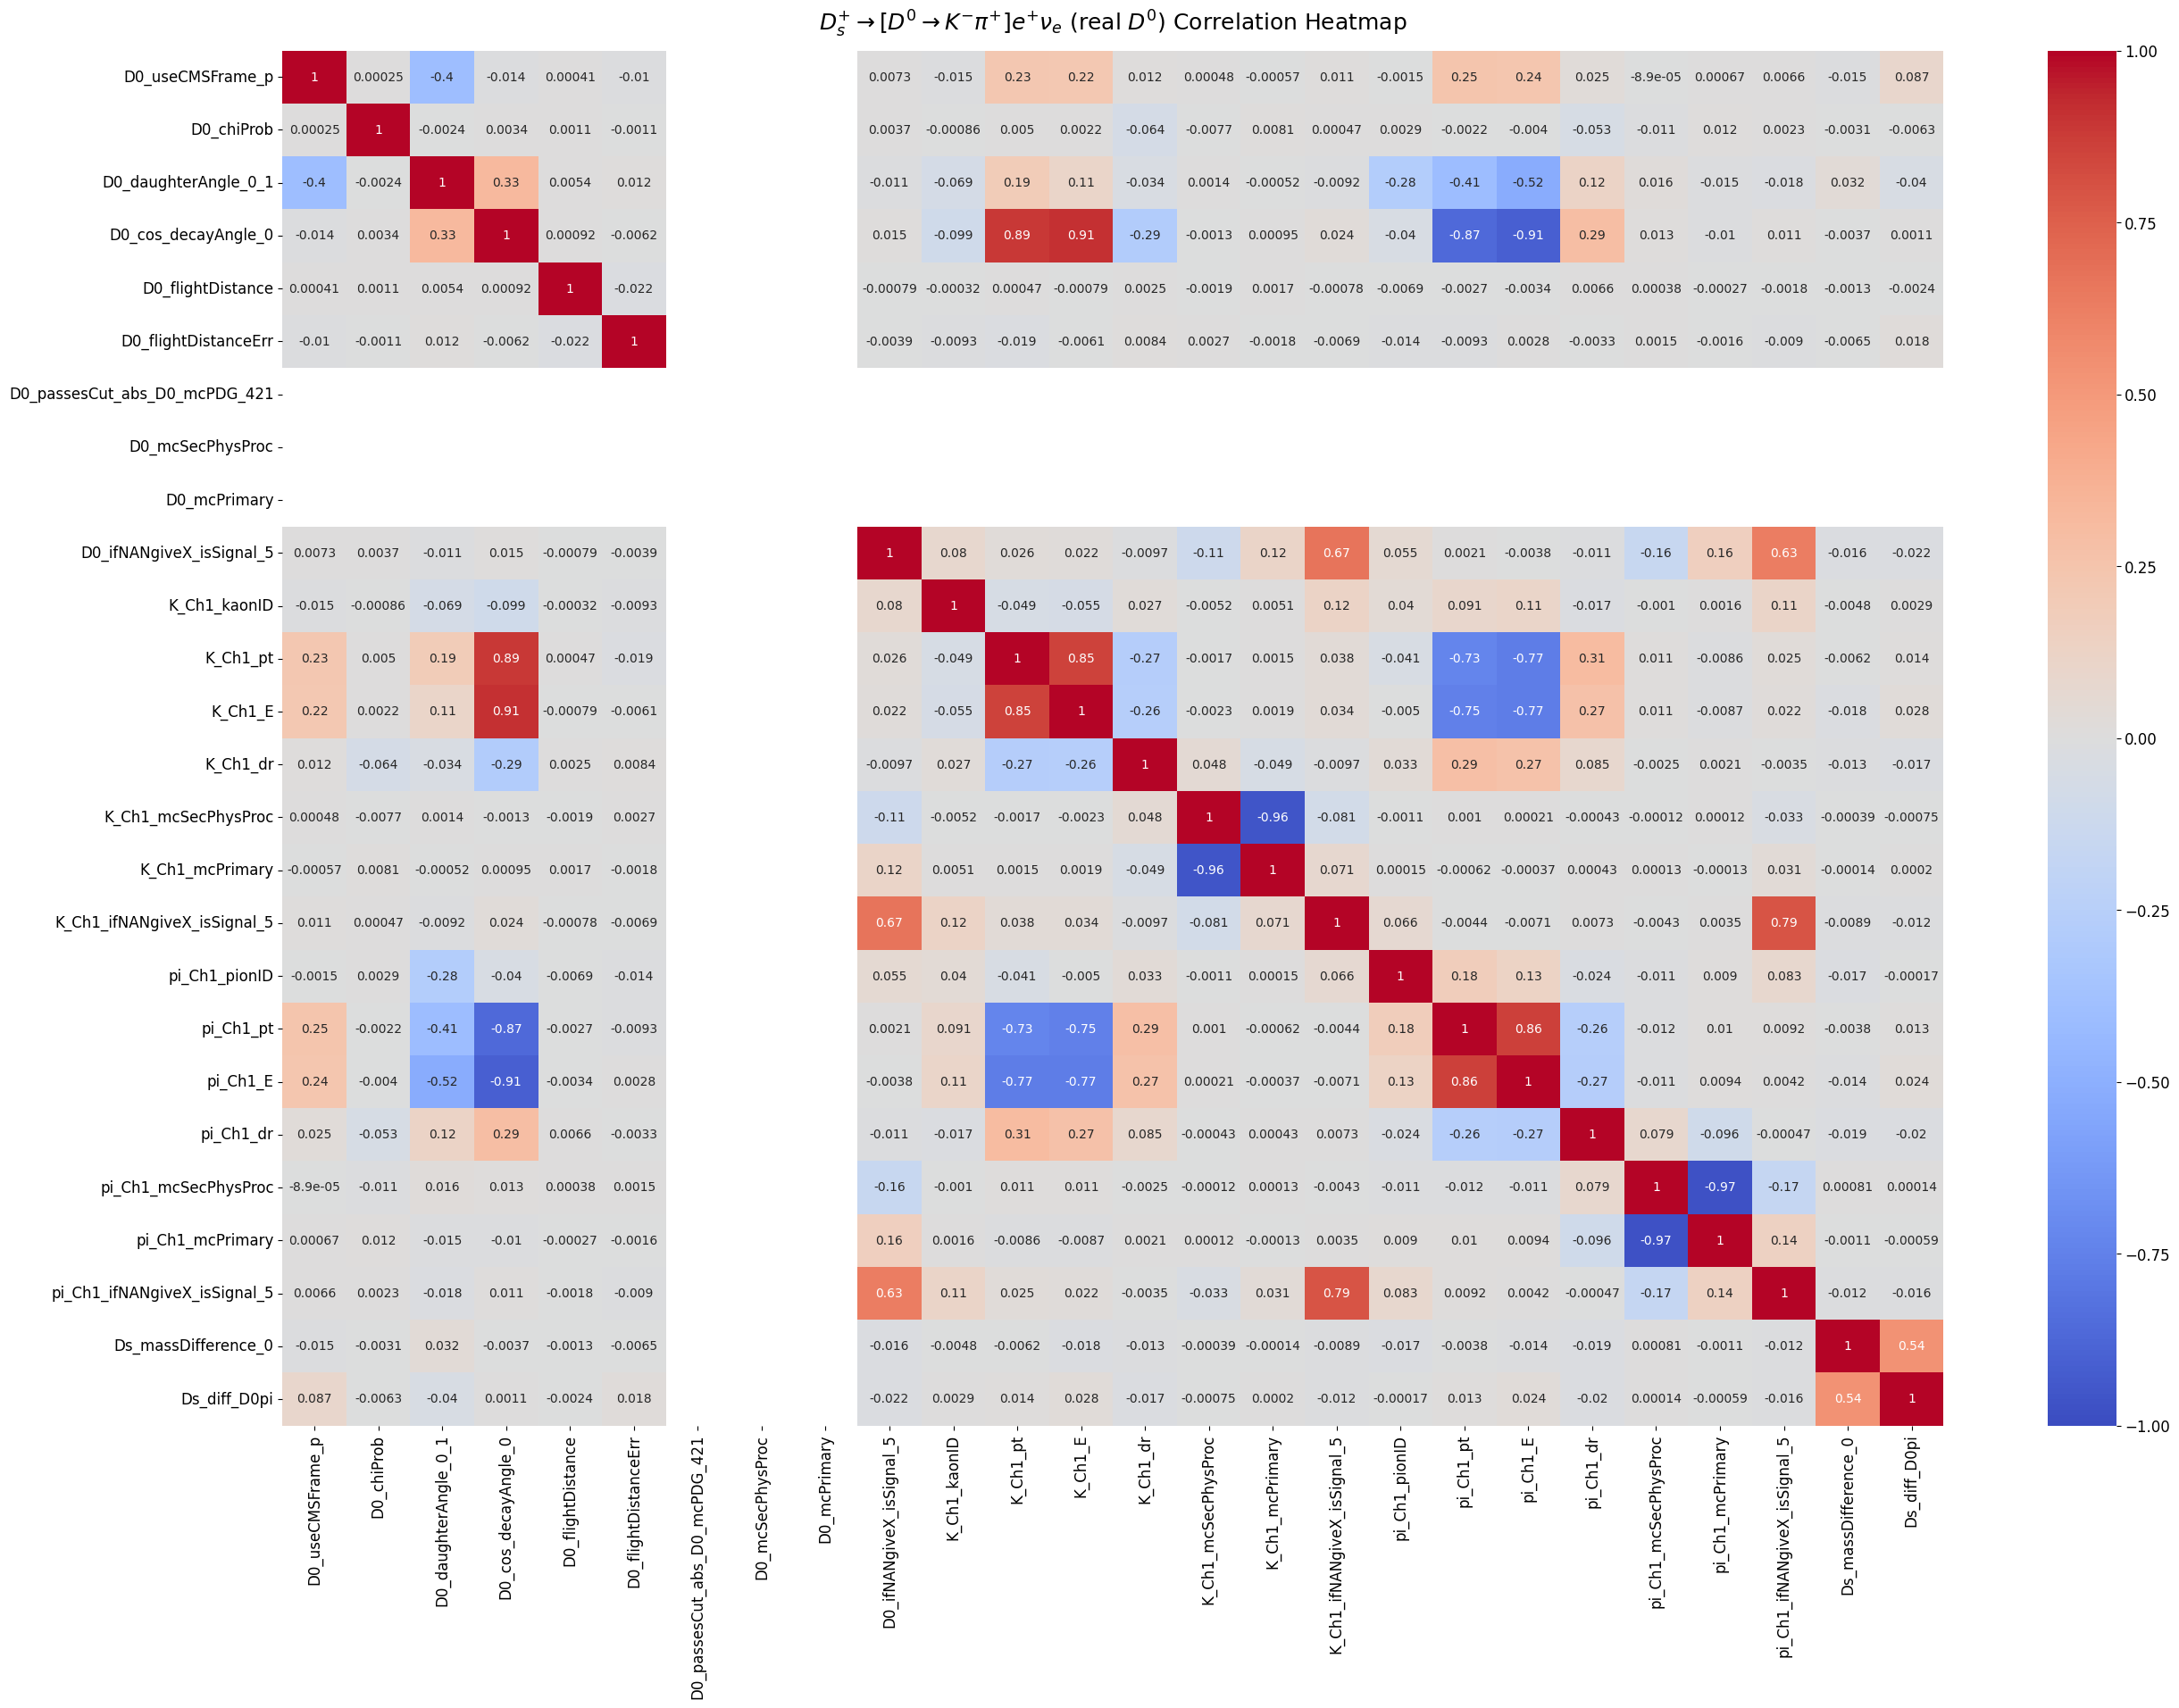

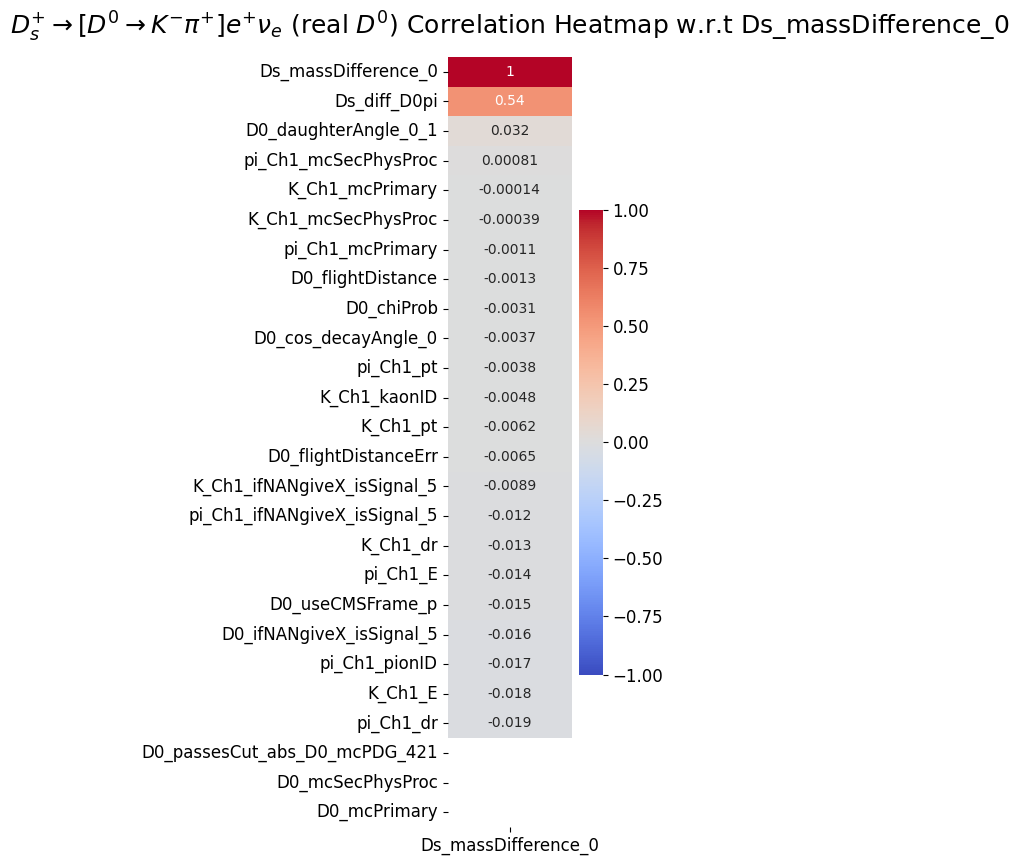

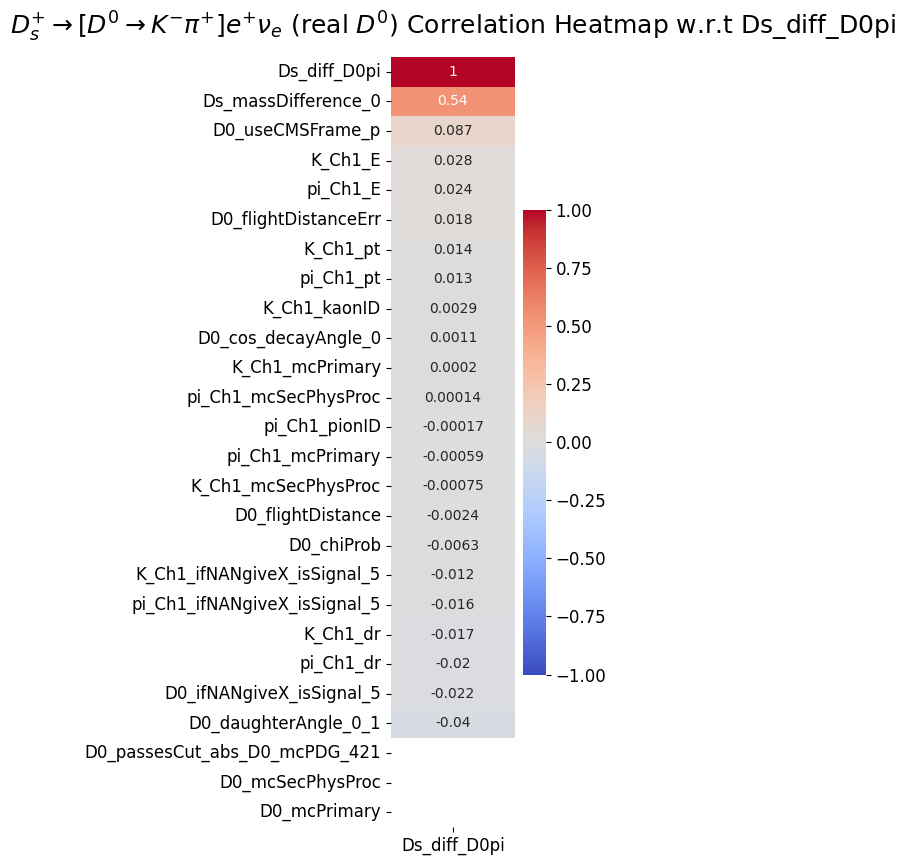


  -> Fake D0 correlations


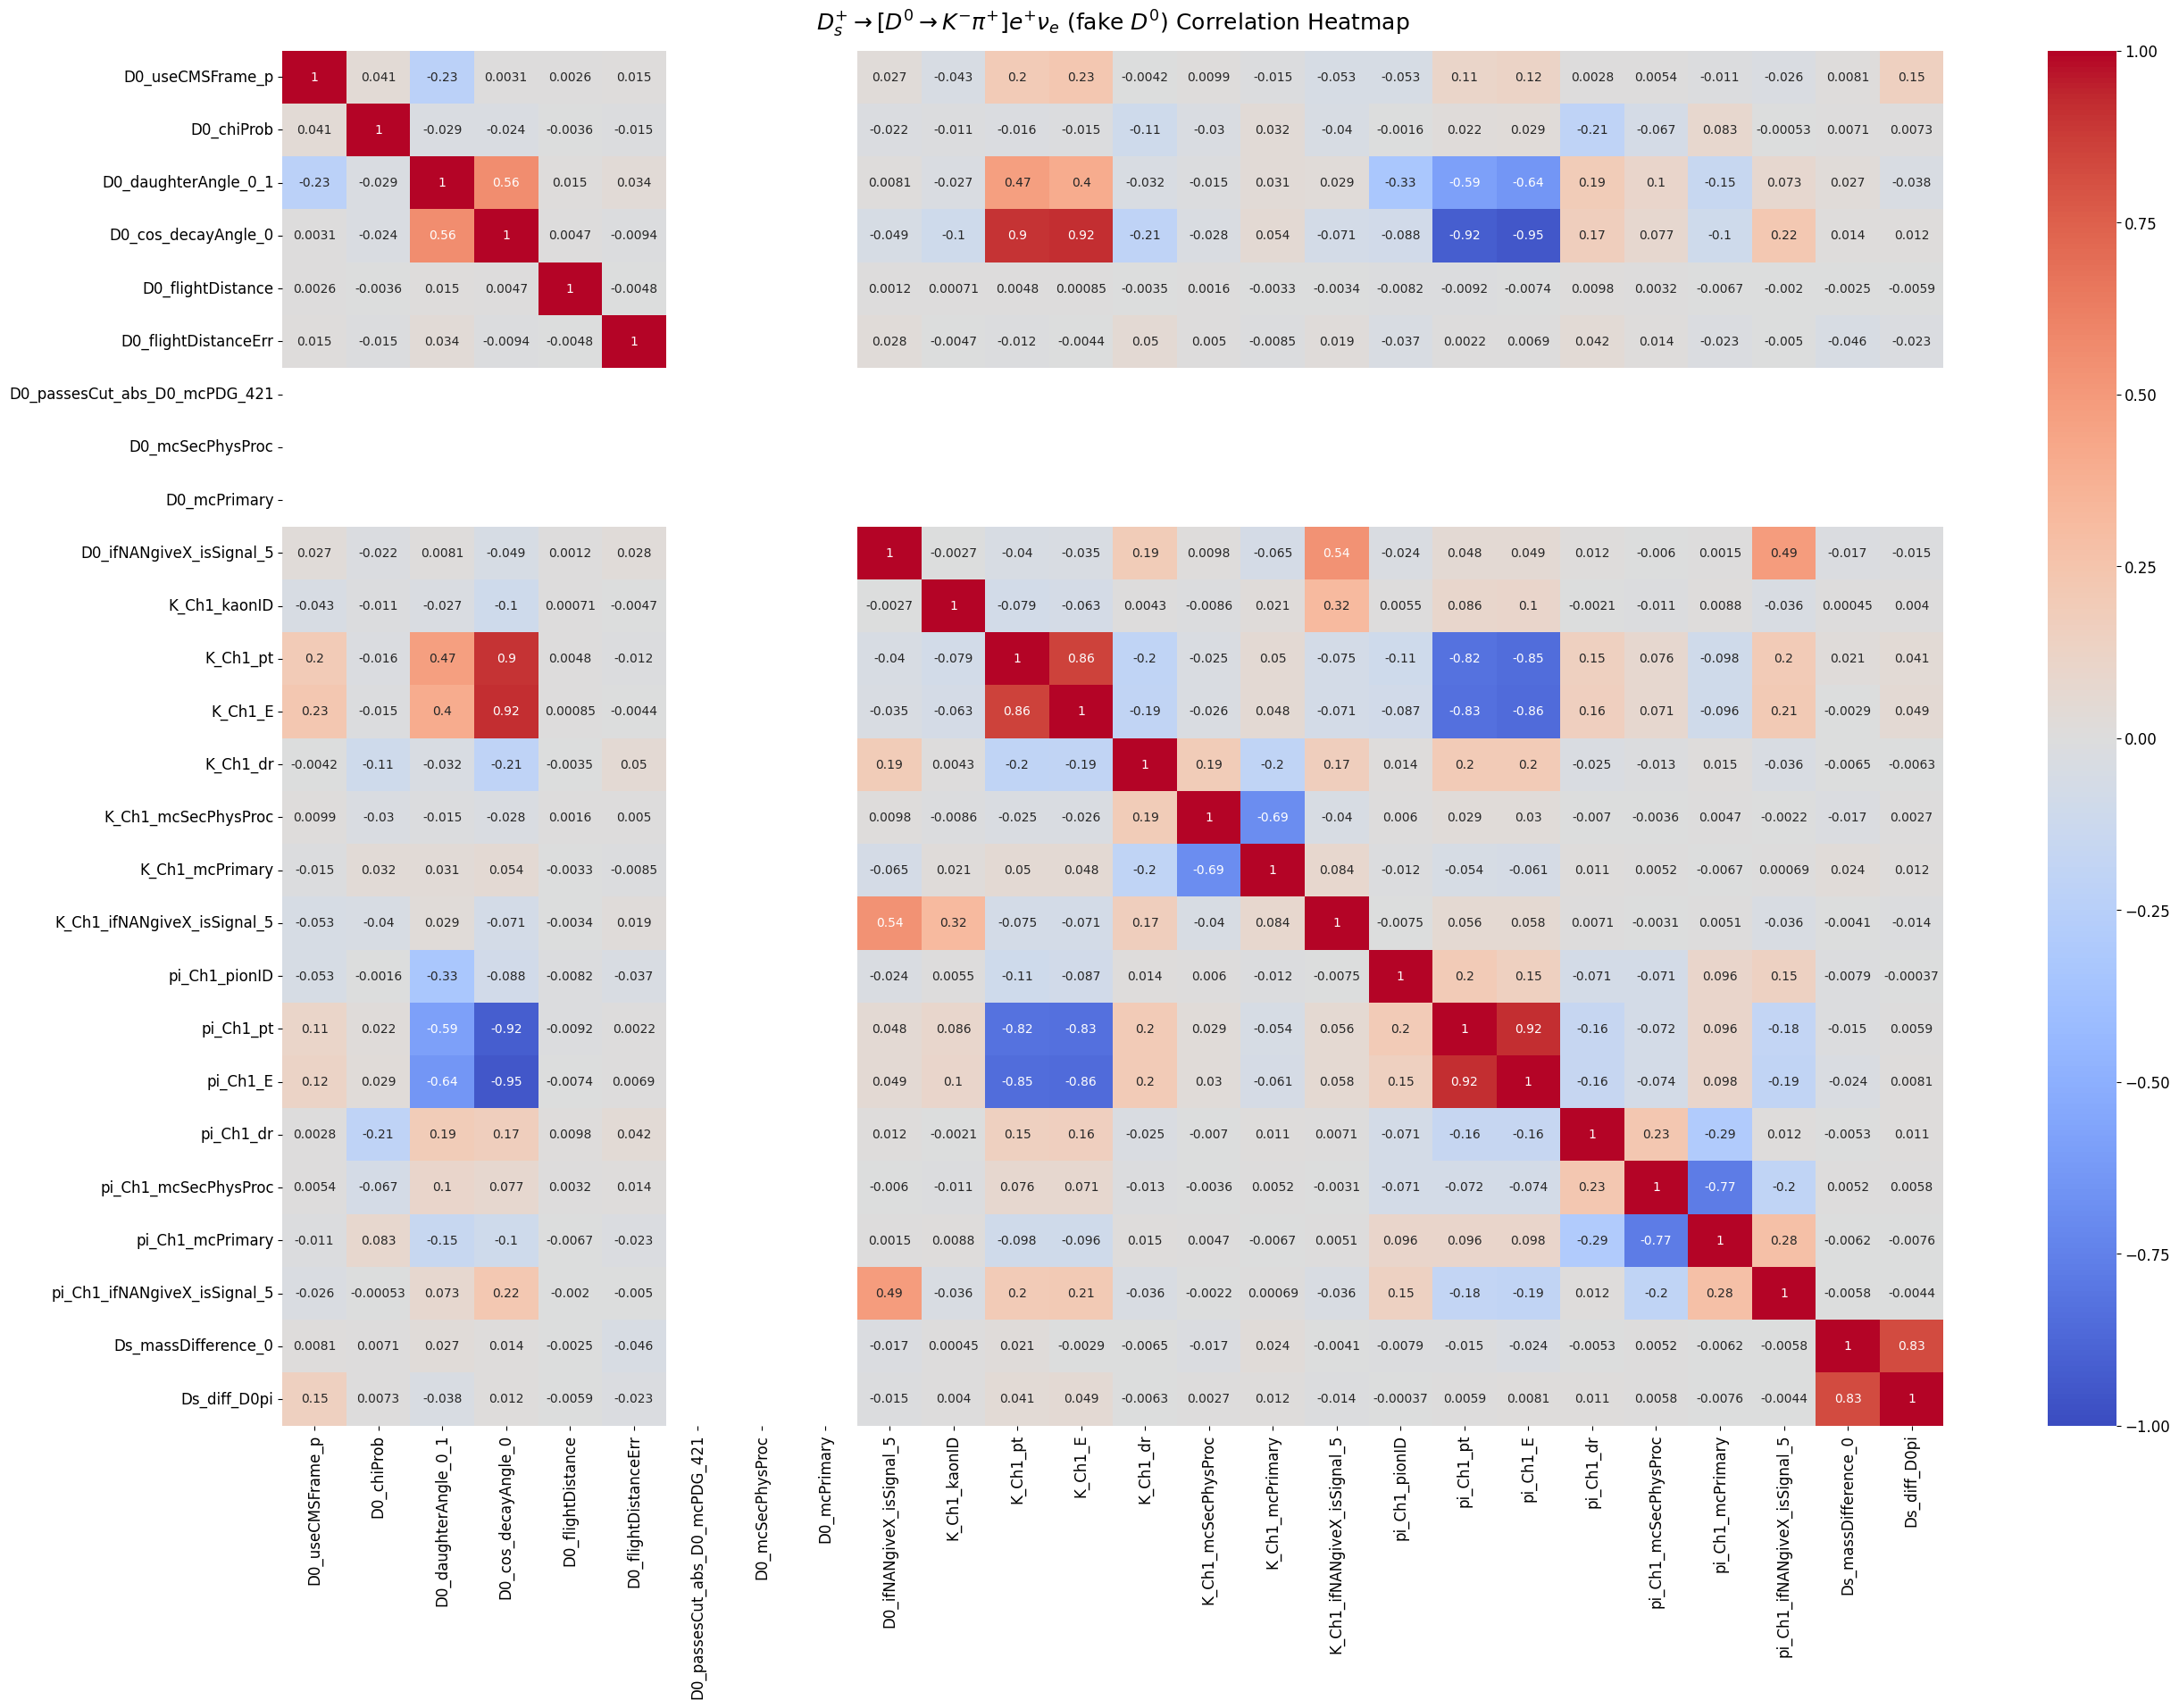

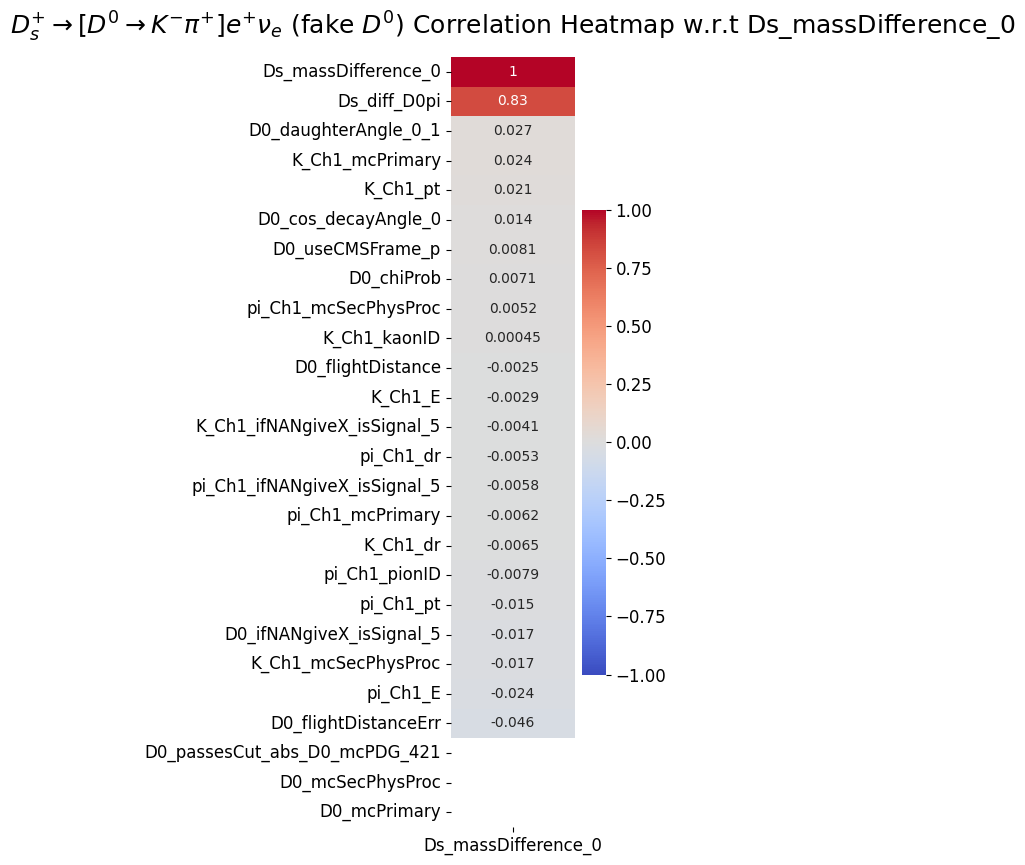

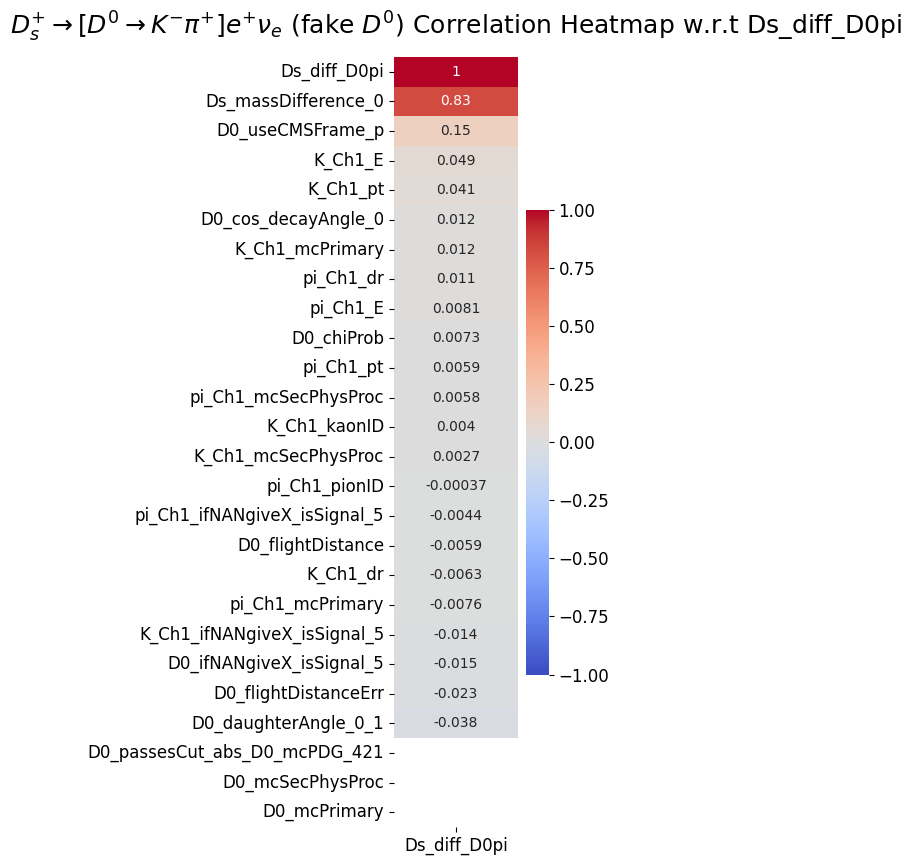


Correlation study for mode: km3pi
  ⚠ Dropping K_Ch3_chi2: contains infinity values
  ⚠ Dropping pi1_Ch3_chi2: contains infinity values
  ⚠ Dropping pi2_Ch3_chi2: contains infinity values
  ⚠ Dropping pi3_Ch3_chi2: contains infinity values
  ⚠ Dropping D0_vertexDistance: 100.0% NaN values
  ⚠ Dropping D0_vertexDistanceErr: 100.0% NaN values
  N_real D0 (signal + generic): 435300
  N_fake D0 (generic only)    : 385455

  -> Real D0 correlations


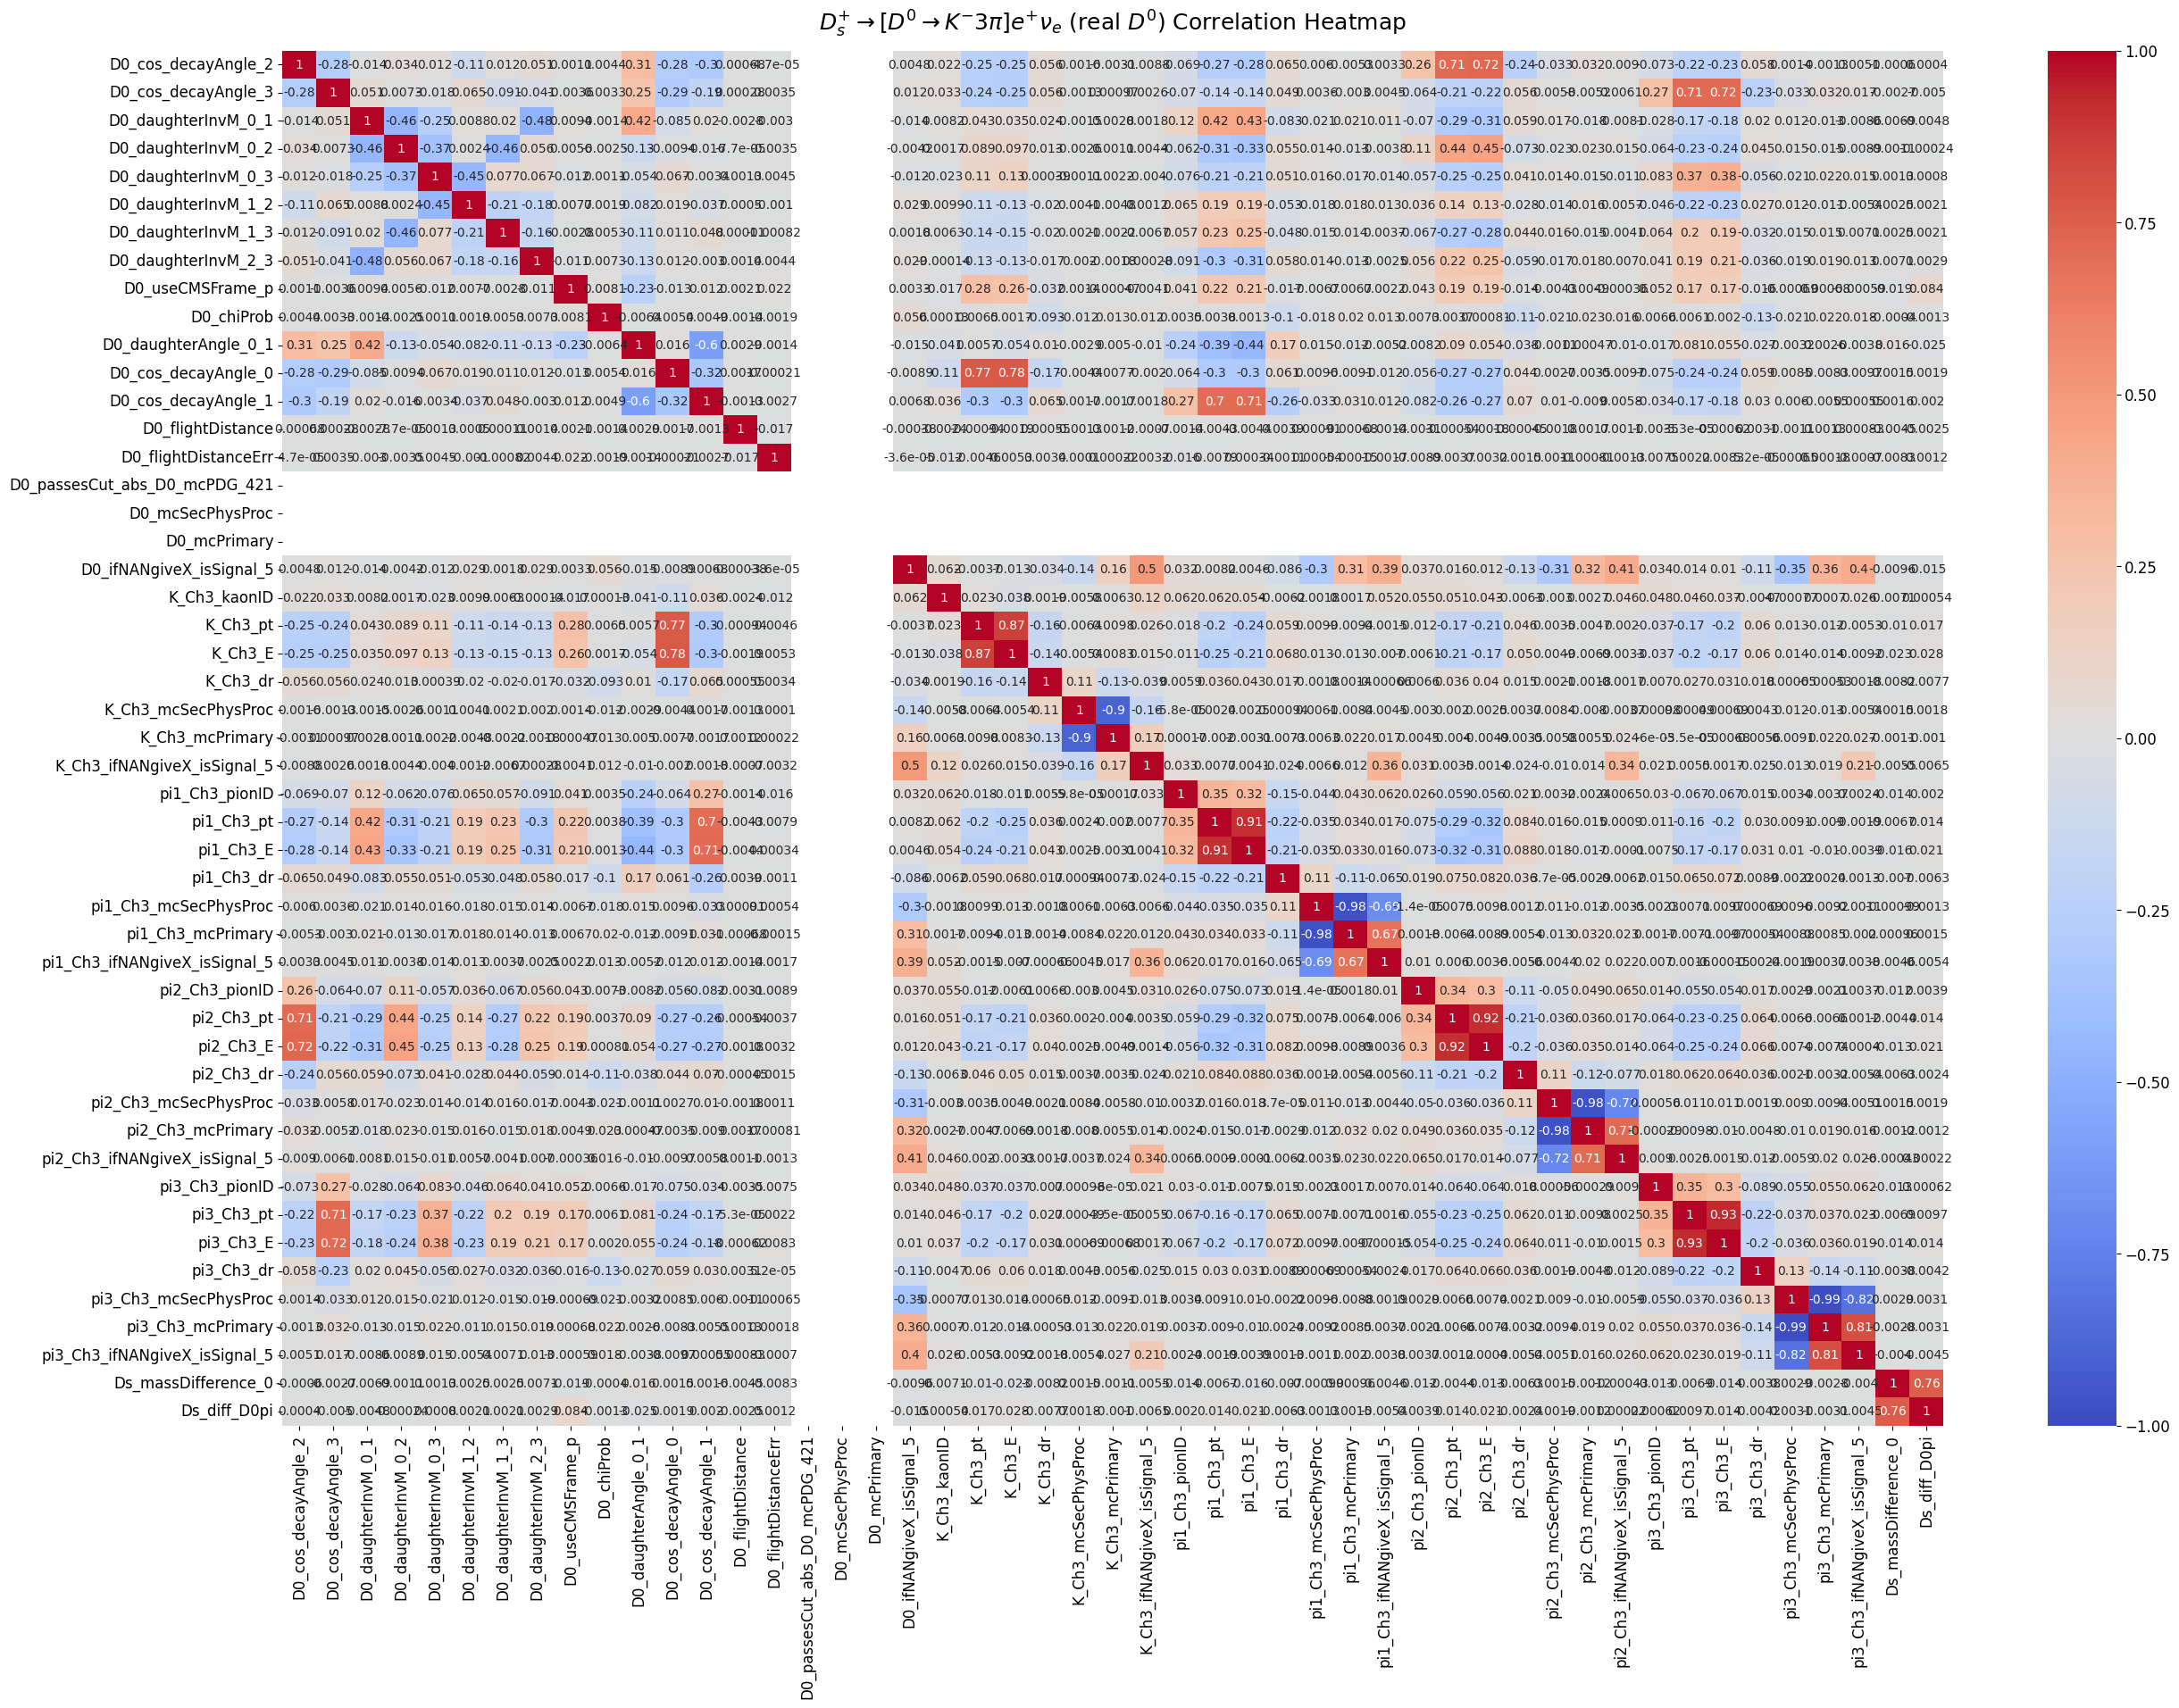

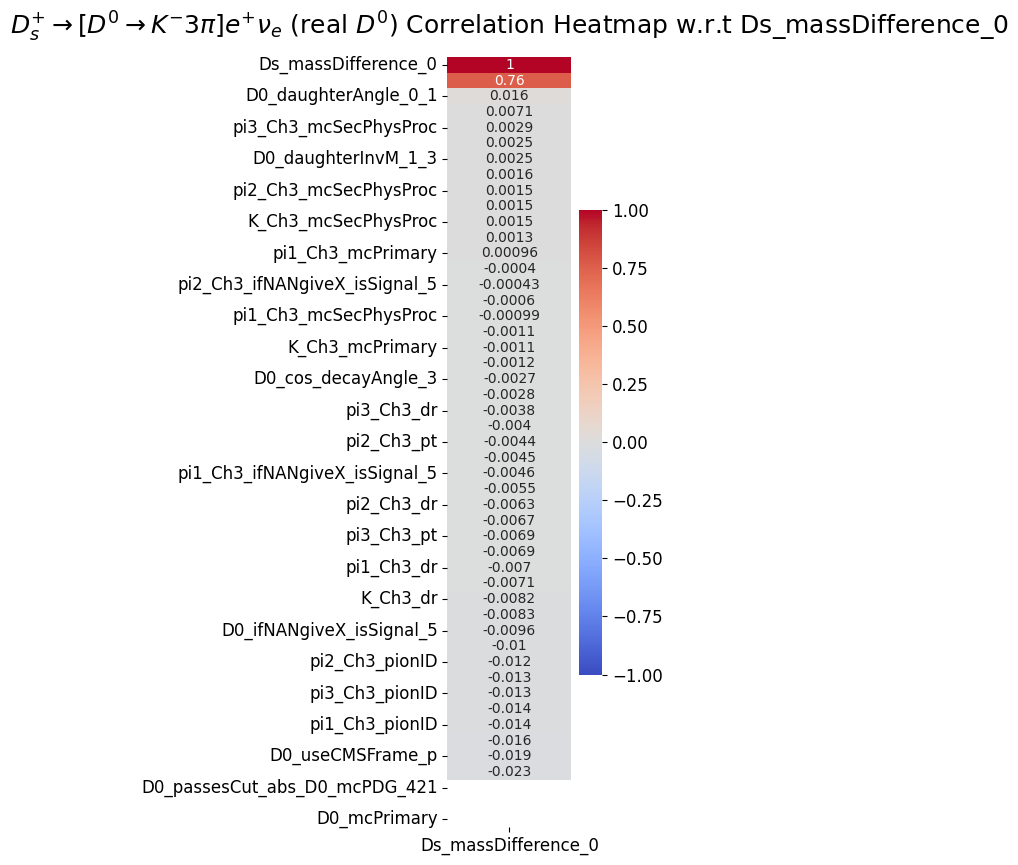

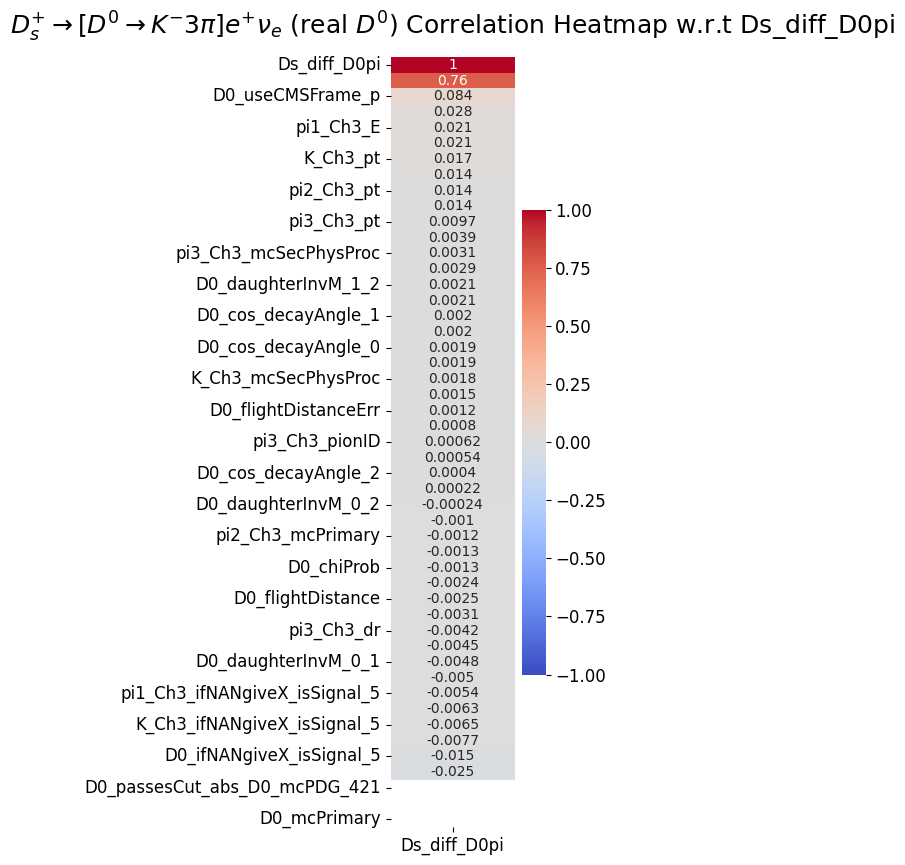


  -> Fake D0 correlations


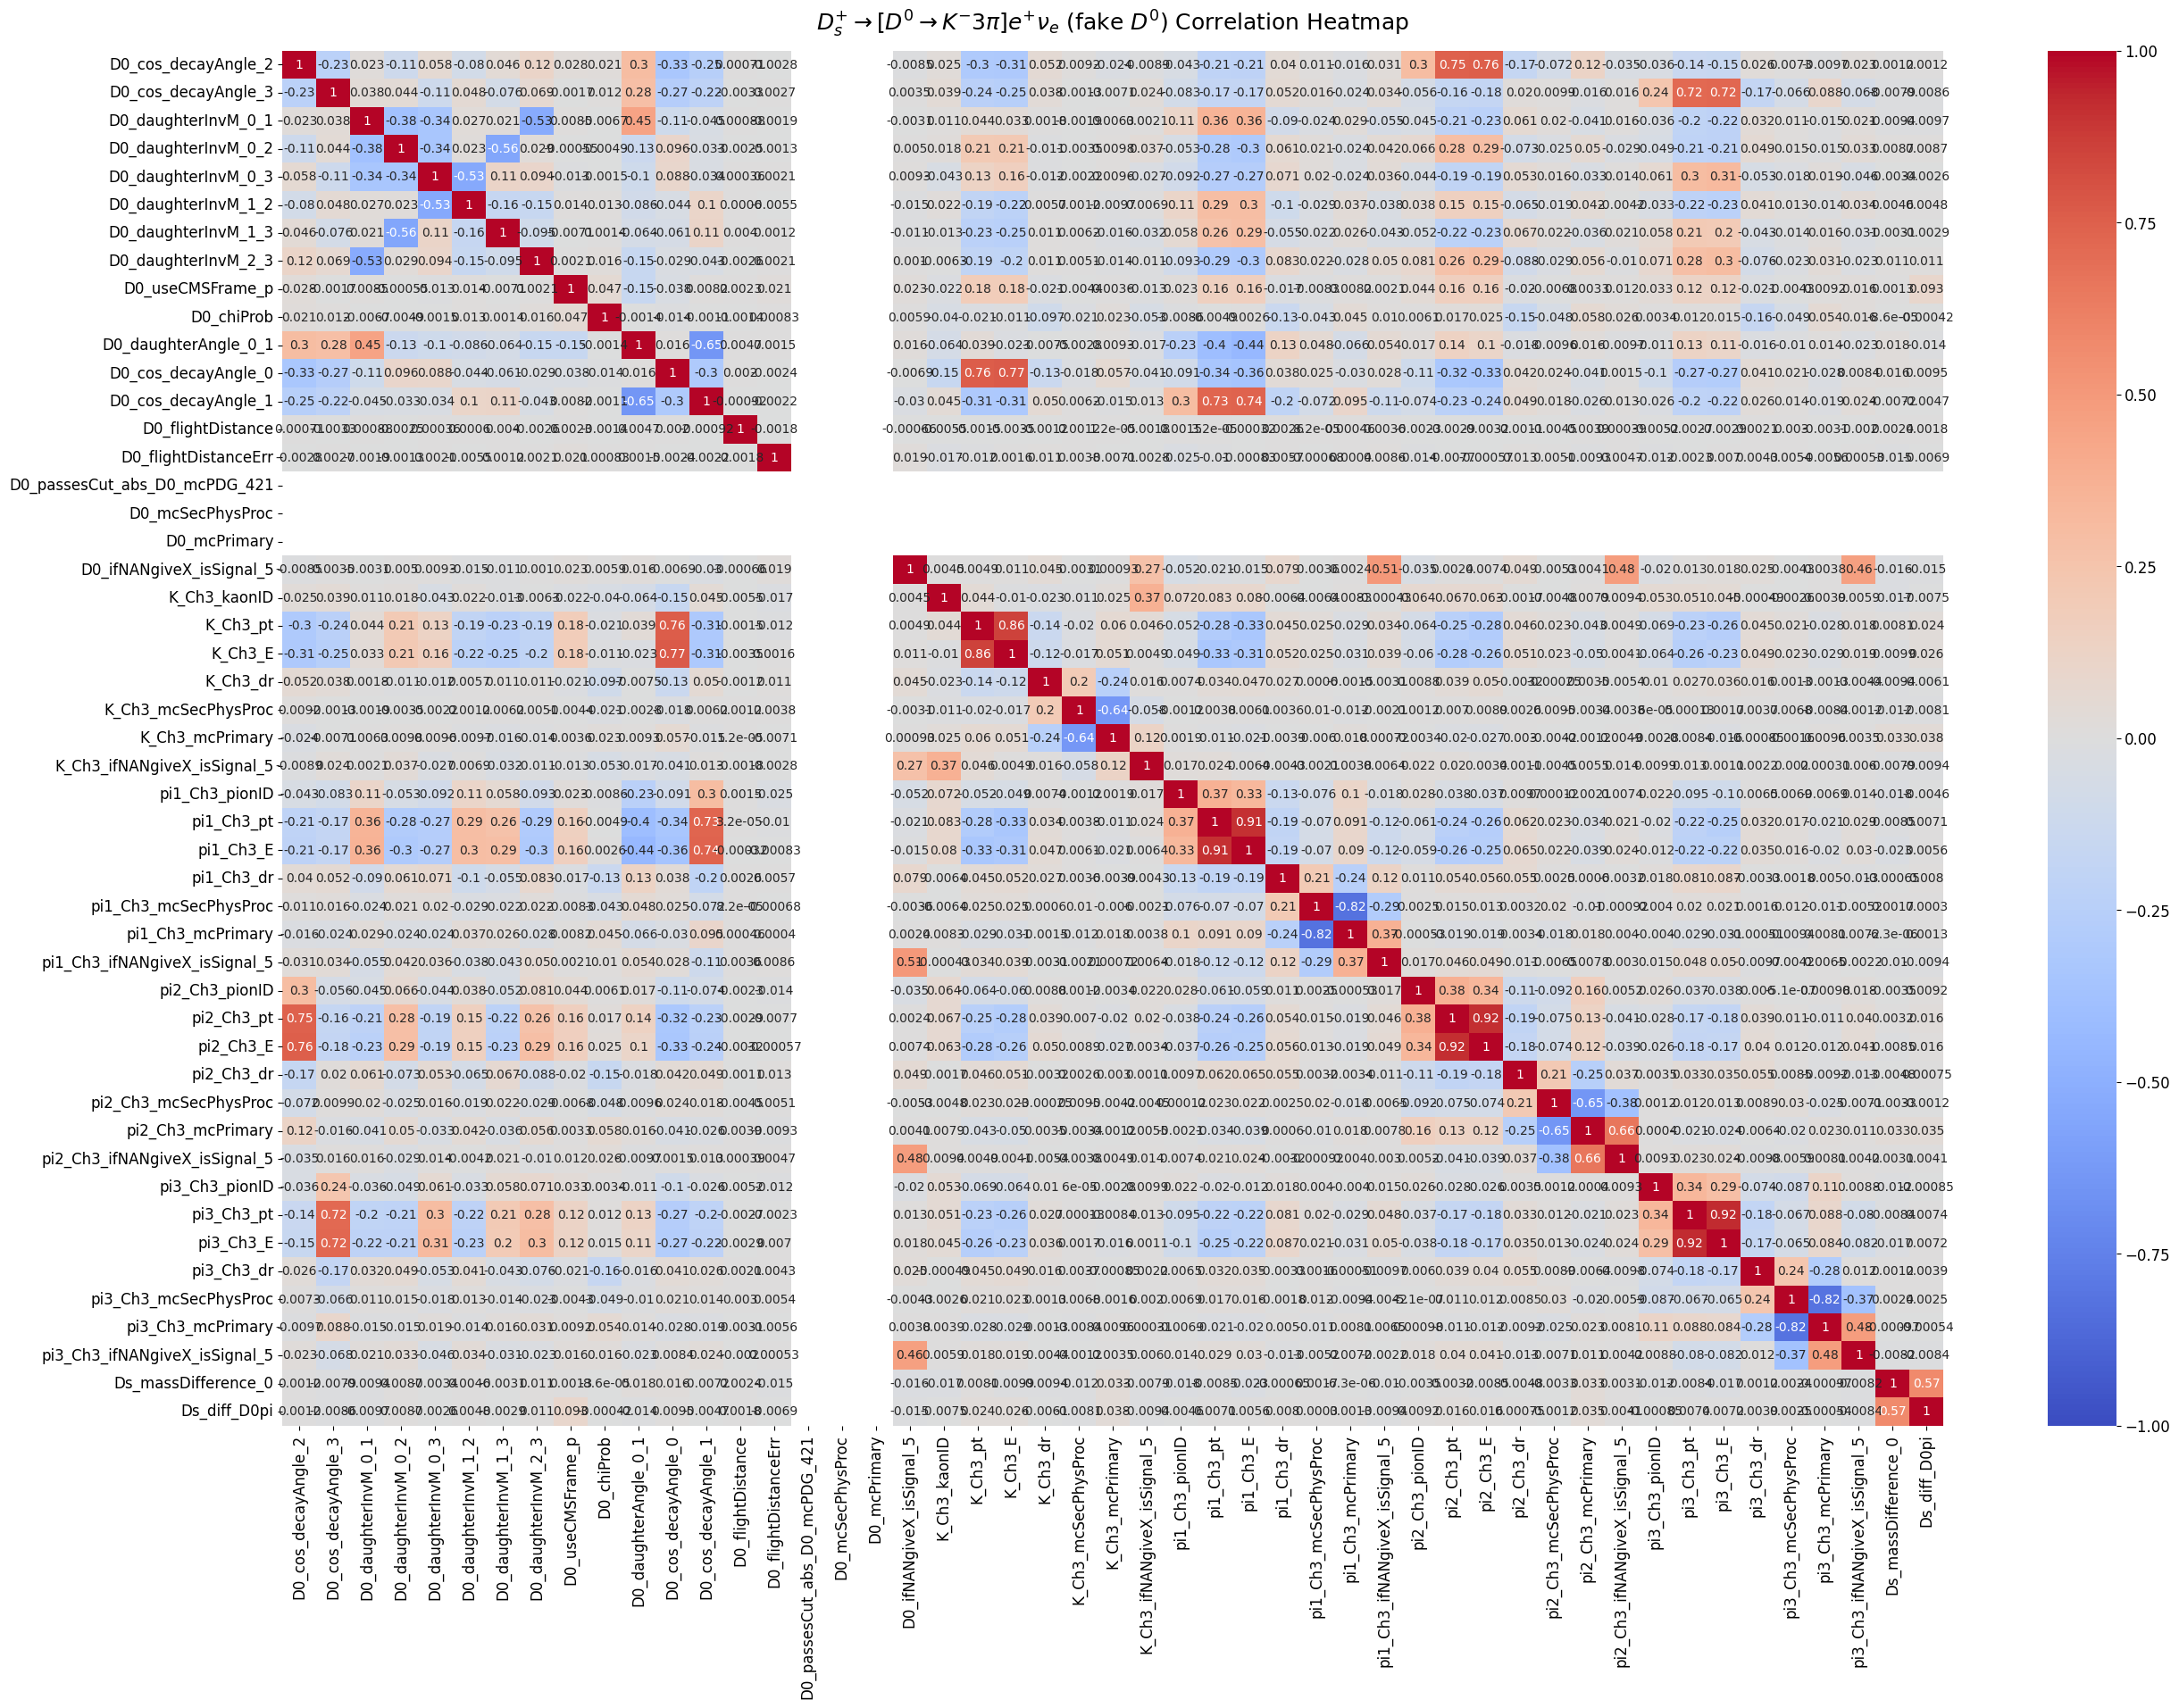

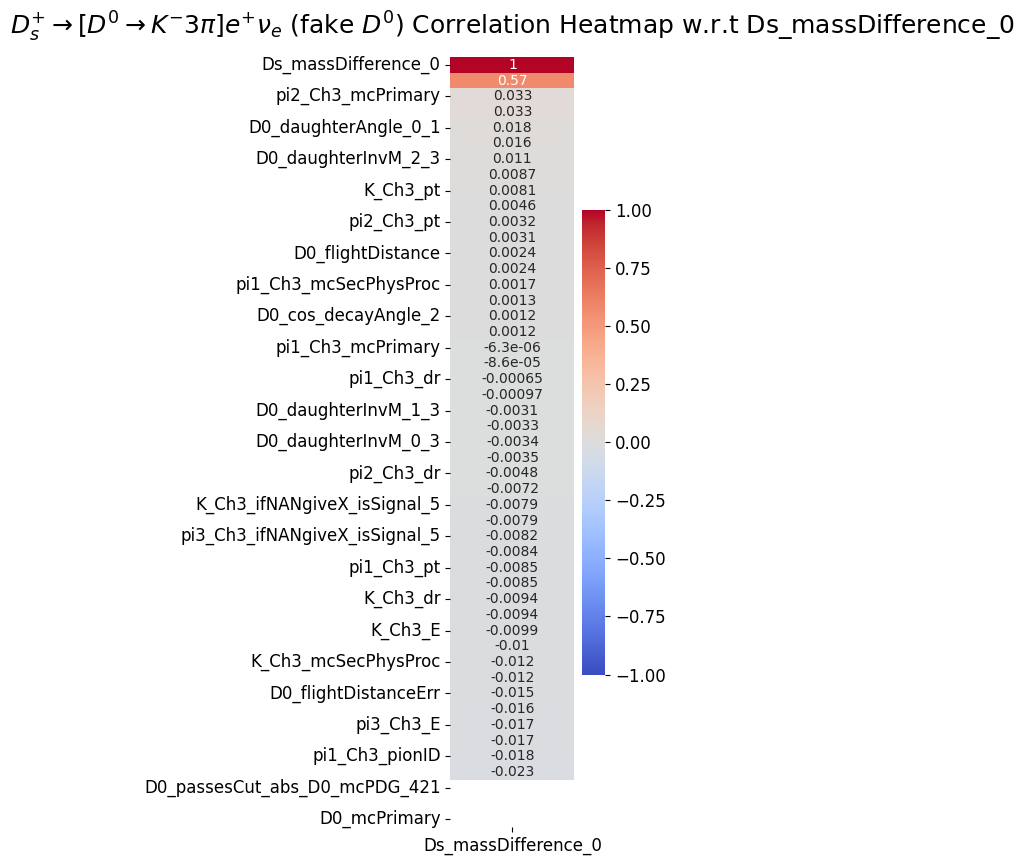

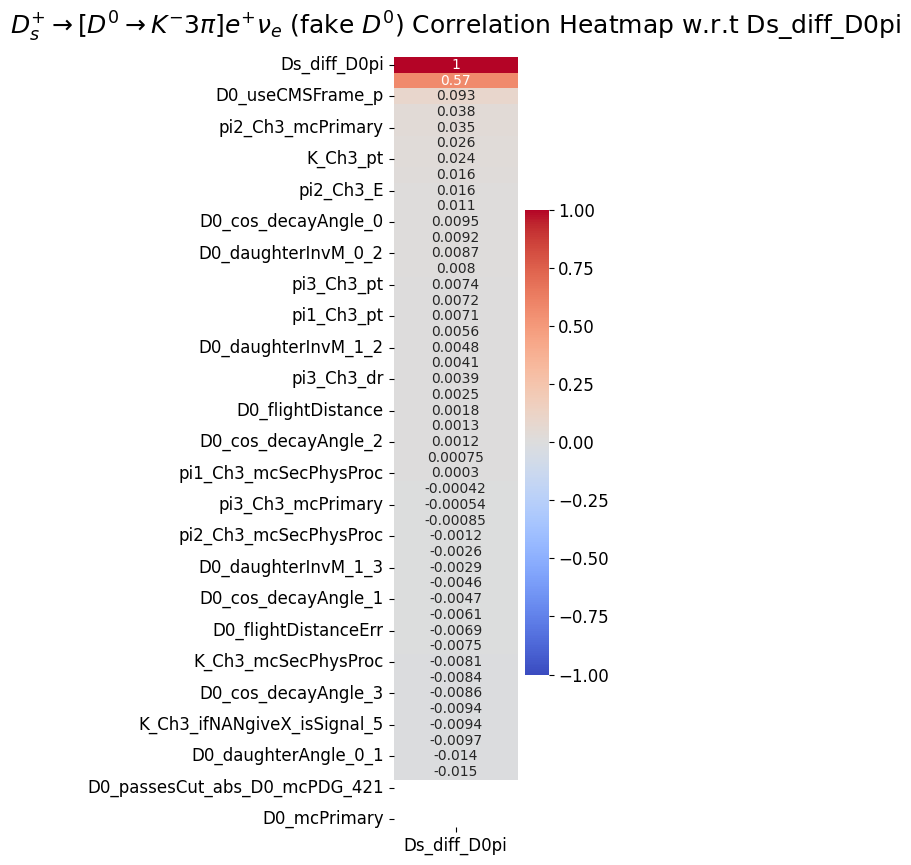


Correlation study for mode: kmpippi0_eff20_May2020
  ⚠ Dropping K_Ch2_chi2: contains infinity values
  ⚠ Dropping pi_Ch2_chi2: contains infinity values
  ⚠ Dropping D0_vertexDistance: 100.0% NaN values
  ⚠ Dropping D0_vertexDistanceErr: 100.0% NaN values
  N_real D0 (signal + generic): 474192
  N_fake D0 (generic only)    : 798125

  -> Real D0 correlations


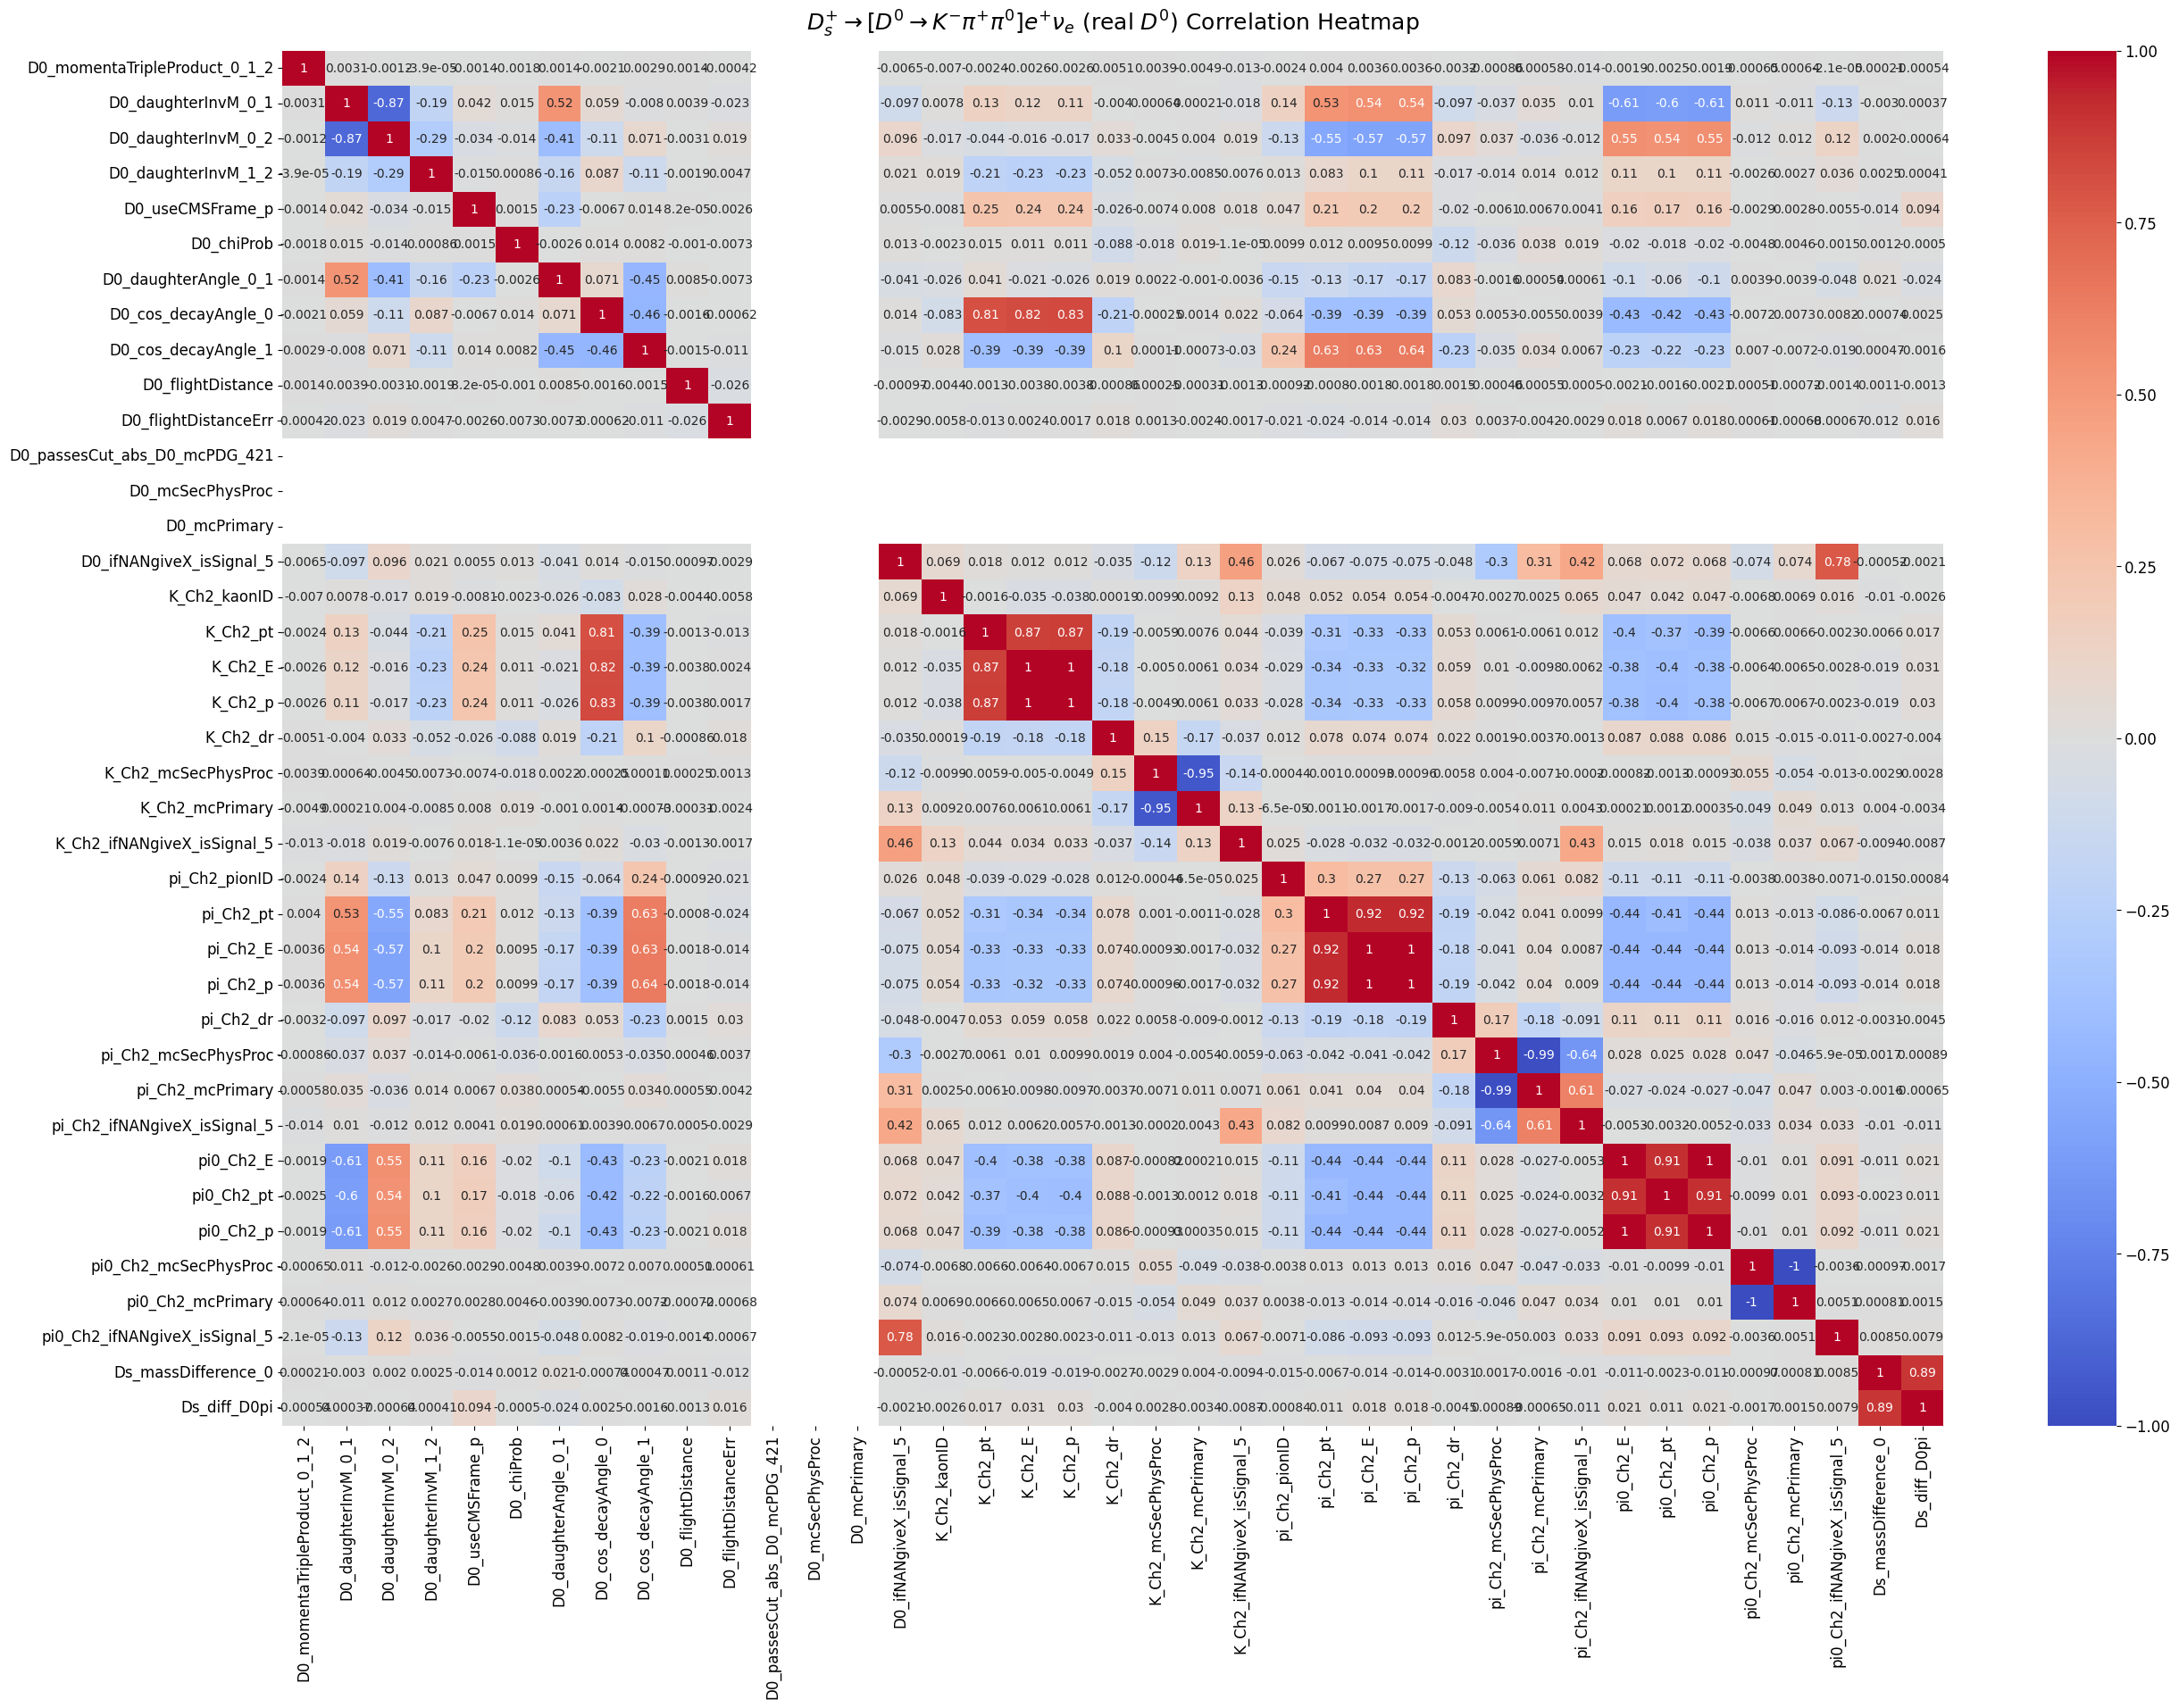

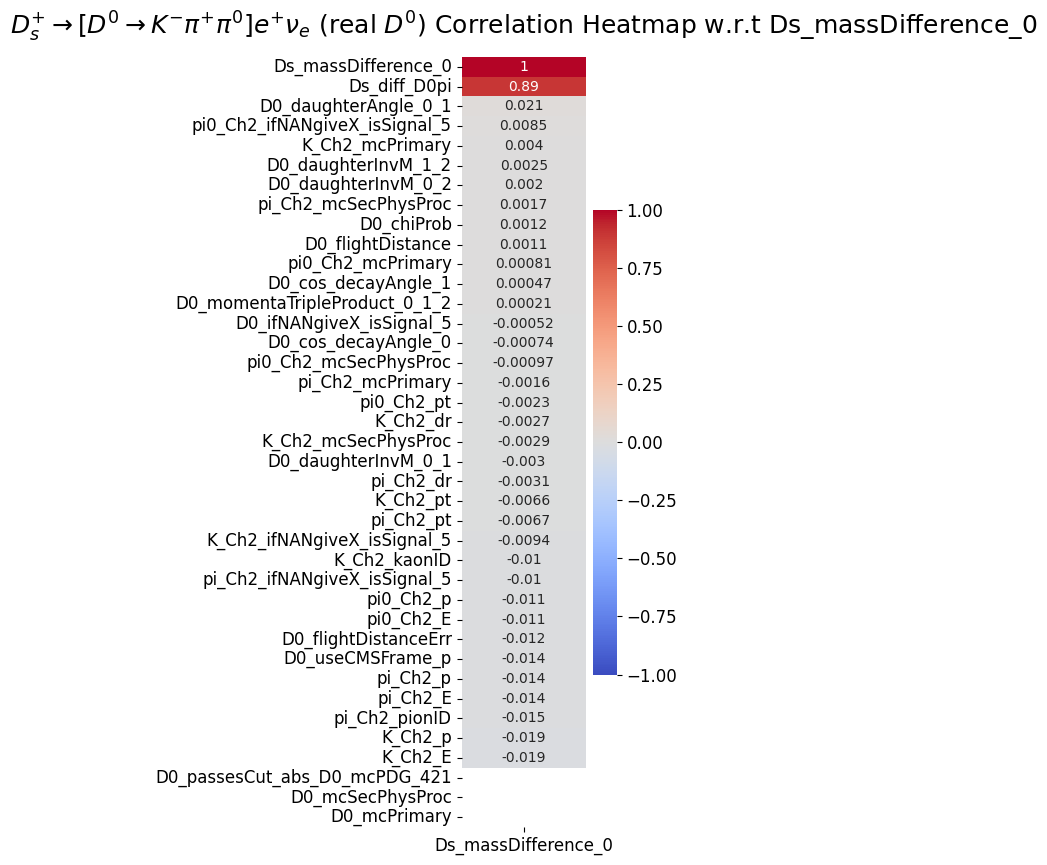

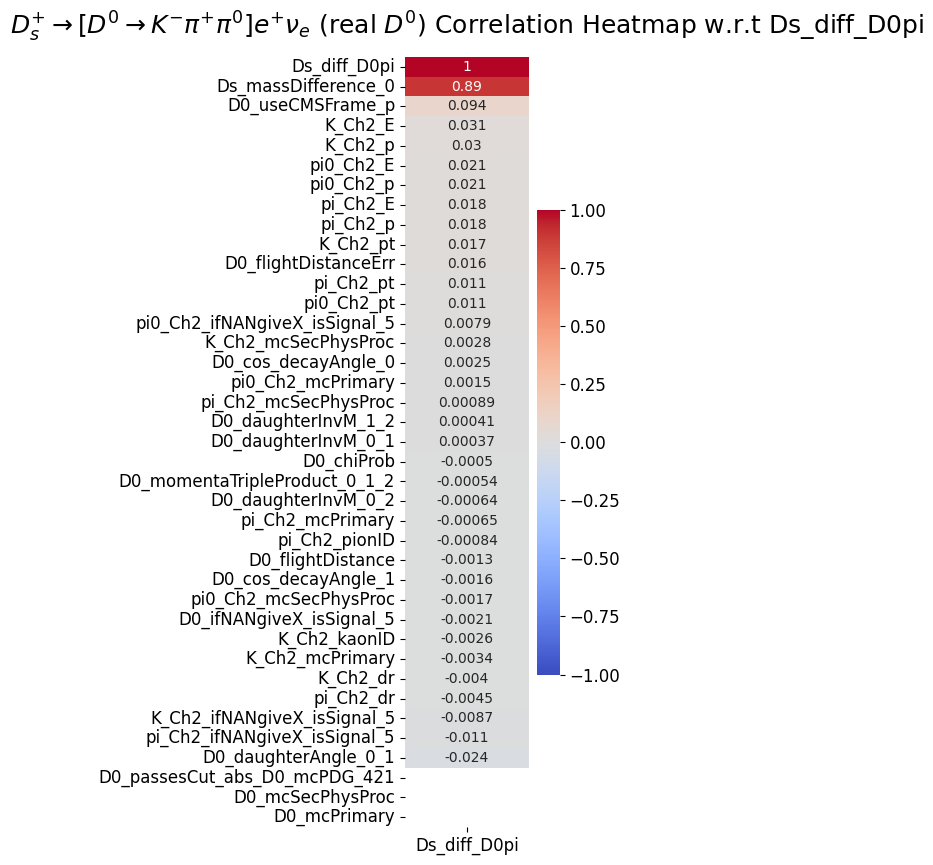


  -> Fake D0 correlations


In [ ]:
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"Correlation study for mode: {mode}")
    print('='*80)

    title_base = mode_titles.get(mode, mode)

    df_sig = DataFrames[f"Signal_{mode}"].copy()
    df_all = DataFrames[f"All_{mode}"].copy()

    # Build var lists from this mode's signal dataframe
    D0_vars, K_vars, pi_vars, pi0_vars, all_vars = get_var_lists(df_sig, mode)

    # ALL vars to use in correlation (excluding fit vars themselves)
    all_vars_corr = [v for v in all_vars if v not in fit_vars]

    # Fit vars that actually exist
    used_fit_vars = [fv for fv in fit_vars if fv in df_sig.columns]
    if len(used_fit_vars) == 0:
        print("  No fit variables found in dataframe, skipping mode.")
        continue

    # Define real and fake D0 (mode by mode)
    if "D0_mcPDG" not in df_sig.columns or "D0_mcPDG" not in df_all.columns:
        print("  D0_mcPDG missing, skipping mode.")
        continue

    # Real: abs(D0_mcPDG) == 421 (D0 and D̄0), from signal and generic
    real_sig = df_sig[abs(df_sig["D0_mcPDG"]) == 421].copy()
    real_bkg = df_all[abs(df_all["D0_mcPDG"]) == 421].copy()

    # Fake: everything else in generic (including NaN)
    fake_bkg = df_all[(abs(df_all["D0_mcPDG"]) != 421) | (df_all["D0_mcPDG"].isna())].copy()

    df_real = pd.concat([real_sig, real_bkg], ignore_index=True)
    df_fake = fake_bkg

    print(f"  N_real D0 (signal + generic): {len(df_real)}")
    print(f"  N_fake D0 (generic only)    : {len(df_fake)}")

    # --------------------------------------------------------
    # Helper to compute and plot correlations for one sample
    # --------------------------------------------------------
    def do_corr_plots(df_sample, sample_label):
        if len(df_sample) == 0:
            print(f"  No entries for {sample_label}, skipping.")
            return

        # Features = ALL vars (D0, K, pi, pi0) + fit vars
        features = [v for v in all_vars_corr + used_fit_vars if v in df_sample.columns]
        if len(features) == 0:
            print(f"  No usable features for {sample_label}, skipping.")
            return

        # Let corr() handle NaNs pairwise
        df_corr = df_sample[features]

        # ---------------------------
        # Full correlation matrix
        # ---------------------------
        plt.figure(figsize=(30, 20))
        heatmap = sns.heatmap(
            df_corr.corr(),
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1
        )
        heatmap.set_title(
            f"{title_base} ({sample_label}) Correlation Heatmap",
            fontdict={'fontsize': 18},
            pad=16
        )
        plt.show()

        # ---------------------------
        # 1-column heatmaps vs each fit var
        # ---------------------------
        for fv in used_fit_vars:
            if fv not in df_corr.columns:
                continue

            corr_col = df_corr.corr()[[fv]].sort_values(
                by=fv, ascending=False
            )

            plt.figure(figsize=(2, 10))
            heatmap = sns.heatmap(
                corr_col,
                cmap="coolwarm",
                annot=True,
                vmin=-1,
                vmax=1
            )
            heatmap.set_title(
                f"{title_base} ({sample_label}) Correlation Heatmap w.r.t {fv}",
                fontdict={'fontsize': 18},
                pad=16
            )
            plt.show()

    # Real D0 correlations
    print("\n  -> Real D0 correlations")
    do_corr_plots(df_real, sample_label="real $D^{0}$")

    # Fake D0 correlations
    print("\n  -> Fake D0 correlations")
    do_corr_plots(df_fake, sample_label="fake $D^{0}$")

  ## Real vs fake D⁰ distributions for K_*, pi_*, pi0_*, D0_* variables

  For each mode:
  * Real/fake definition same as above
  * Lists of:
    * D0_*,
    * K_*,
    * pi_*,
    * pi0_*,
    after applying per-mode manual_drop_vars and numeric-only
  * For each variable:
    * Range = [1st percentile, 99th percentile] (combined real+fake)
    * Real vs fake with:
      * "purple" for real,
      * "#D55E00" for fake,
      * linewidth 2.5,
      * density=False (raw entries per bin)
  * Title = decay chain only
  * Y label includes the bin width value

In [11]:
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"Real vs fake D0 distributions - mode: {mode}")
    print('='*80)

    title_base = mode_titles.get(mode, mode)

    df_sig = DataFrames[f"Signal_{mode}"].copy()
    df_all = DataFrames[f"All_{mode}"].copy()

    if "D0_mcPDG" not in df_sig.columns or "D0_mcPDG" not in df_all.columns:
        print("  D0_mcPDG missing, skipping mode.")
        continue

    # Real: abs(D0_mcPDG) == 421 (D0 and D̄0), from signal and generic
    real_sig = df_sig[abs(df_sig["D0_mcPDG"]) == 421].copy()
    real_bkg = df_all[abs(df_all["D0_mcPDG"]) == 421].copy()

    # Fake: everything else in generic (including NaN)
    fake_bkg = df_all[(abs(df_all["D0_mcPDG"]) != 421) | (df_all["D0_mcPDG"].isna())].copy()

    df_real = pd.concat([real_sig, real_bkg], ignore_index=True)
    df_fake = fake_bkg

    print(f"  N_real D0 (signal + generic): {len(df_real)}")
    print(f"  N_fake D0 (generic only)    : {len(df_fake)}")

    if len(df_real) == 0 or len(df_fake) == 0:
        print("  Either real or fake sample is empty, skipping histograms for this mode.")
        continue

    # Build lists of variables for this mode (from real sample)
    D0_vars, K_vars, pi_vars, pi0_vars, all_vars = get_var_lists(df_real, mode)

    print(f"  N_D0 vars  : {len(D0_vars)}")
    print(f"  N_K vars   : {len(K_vars)}")
    print(f"  N_pi vars  : {len(pi_vars)}")
    print(f"  N_pi0 vars : {len(pi0_vars)}")

    # Loop over all vars (D0 + daughters)
    for v in all_vars:
        if v not in df_real.columns or v not in df_fake.columns:
            continue

        x_real = df_real[v].to_numpy()
        x_fake = df_fake[v].to_numpy()

        # keep finite values only
        x_real = x_real[np.isfinite(x_real)]
        x_fake = x_fake[np.isfinite(x_fake)]

        if len(x_real) == 0 or len(x_fake) == 0:
            continue

        # automatic range using 1–99 percentile to avoid crazy tails
        x_combined = np.concatenate([x_real, x_fake])
        x_combined = x_combined[np.isfinite(x_combined)]
        if len(x_combined) == 0:
            continue

        low = np.nanpercentile(x_combined, 1)
        high = np.nanpercentile(x_combined, 99)

        if not np.isfinite(low) or not np.isfinite(high) or low == high:
            continue

        # bin width in the variable's native units
        per_bin = (high - low) / BINS_HIST
        print(f"  {mode}, {v}: bin width = {per_bin:.6g}")

        plt.hist(
            x_real,
            bins=BINS_HIST,
            range=[low, high],
            histtype='step',
            color=COLOR_REAL,
            linewidth=LINEWIDTH,
            density=DENSITY_HIST,
            label='Real $D^{0}$ (|mcPDG| = 421)'
        )

        plt.hist(
            x_fake,
            bins=BINS_HIST,
            range=[low, high],
            histtype='step',
            color=COLOR_FAKE,
            linewidth=LINEWIDTH,
            density=DENSITY_HIST,
            label='Fake $D^{0}$'
        )

        plt.title(title_base, loc="left")
        # Just keep the numerical value, no explicit unit label
        plt.ylabel(f"Entries / ({per_bin:.3g})")
        plt.xlabel(v)
        plt.legend()
        plt.show()

  ## Dalitz plot: real vs fake D⁰ (kmpippi0_eff20_May2020, generic MC only)
     x = m²(K⁻π⁺), y = m²(π⁺π⁰)

In [12]:
mode_dalitz = "kmpippi0_eff20_May2020"

if f"All_{mode_dalitz}" not in DataFrames:
    print(f"[Dalitz] Background dataframe All_{mode_dalitz} not found, skipping.")
else:
    df_bkg = DataFrames[f"All_{mode_dalitz}"].copy()

    required_cols = [
        "D0_mcPDG",
        "D0_daughterInvM_0_1",  # m(K- pi+)
        "D0_daughterInvM_1_2",  # m(pi+ pi0)
    ]
    missing = [c for c in required_cols if c not in df_bkg.columns]
    if missing:
        print(f"[Dalitz] Missing columns for Dalitz plot: {missing}")
    else:
        mask_real = (df_bkg["D0_mcPDG"].abs() == 421)
        mask_fake = (df_bkg["D0_mcPDG"].abs() != 421) | (df_bkg["D0_mcPDG"].isna())

        def extract_xy(df_sel):
            df_sel = df_sel[["D0_daughterInvM_0_1", "D0_daughterInvM_1_2"]].dropna()
            if df_sel.empty:
                return None, None
            m_kpi   = df_sel["D0_daughterInvM_0_1"].to_numpy(dtype=float)
            m_pipi0 = df_sel["D0_daughterInvM_1_2"].to_numpy(dtype=float)
            x = m_kpi**2
            y = m_pipi0**2
            return x, y

        x_real, y_real = extract_xy(df_bkg[mask_real])
        x_fake, y_fake = extract_xy(df_bkg[mask_fake])

        print(f"[Dalitz] N_real D0 (generic, Dalitz vars non-NaN): {0 if x_real is None else len(x_real)}")
        print(f"[Dalitz] N_fake D0 (generic, Dalitz vars non-NaN): {0 if x_fake is None else len(x_fake)}")

        if (x_real is None) or (x_fake is None):
            print("[Dalitz] One of the samples is empty, skipping Dalitz plot.")
        else:
            fig, axes = plt.subplots(1, 2, figsize=(11, 5))
            ax_real, ax_fake = axes

            # Real D0
            hb_real = ax_real.hexbin(
                x_real,
                y_real,
                gridsize=60,
                bins="log",
                cmap="viridis",
            )
            cb_real = fig.colorbar(hb_real, ax=ax_real)
            cb_real.set_label("Counts")

            ax_real.set_xlabel(r"$m^{2}(K^{-}\pi^{+})\;[\mathrm{GeV}^{2}/c^{4}]$")
            ax_real.set_ylabel(r"$m^{2}(\pi^{+}\pi^{0})\;[\mathrm{GeV}^{2}/c^{4}]$")
            ax_real.set_title(r"Real $D^{0}$ (|mcPDG| = 421)", loc="left")

            # Fake D0
            hb_fake = ax_fake.hexbin(
                x_fake,
                y_fake,
                gridsize=60,
                bins="log",
                cmap="viridis",
            )
            cb_fake = fig.colorbar(hb_fake, ax=ax_fake)
            cb_fake.set_label("Counts")

            ax_fake.set_xlabel(r"$m^{2}(K^{-}\pi^{+})\;[\mathrm{GeV}^{2}/c^{4}]$")
            ax_fake.set_ylabel(r"$m^{2}(\pi^{+}\pi^{0})\;[\mathrm{GeV}^{2}/c^{4}]$")
            ax_fake.set_title(r"Fake $D^{0}$", loc="left")

            # resonance positions
            m_Kstar0 = 0.896
            m_rho    = 0.775
            x_Kstar0 = m_Kstar0**2
            y_rho    = m_rho**2

            for ax in (ax_real, ax_fake):
                ax.axvline(x_Kstar0, color="black", linestyle="--", linewidth=2.0)
                ax.axhline(y_rho,    color="black", linestyle="--", linewidth=2.0)

                x_min, x_max = ax.get_xlim()
                y_min, y_max = ax.get_ylim()

                # K*(892)^0 label with white box
                ax.text(
                    x_Kstar0 + 0.02 * (x_max - x_min),
                    y_max - 0.05 * (y_max - y_min),
                    r"$K^{*}(892)^{0}$",
                    rotation=90,
                    va="top",
                    ha="left",
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2",
                              facecolor="white", alpha=0.8, edgecolor="none"),
                )

                # ρ(770)+ label: centered in the band, with white box
                ax.text(
                    x_min + 0.55 * (x_max - x_min),   # more central in x
                    y_rho + 0.03 * (y_max - y_min),   # slightly above the line
                    r"$\rho(770)^{+}$",
                    va="bottom",
                    ha="center",
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2",
                              facecolor="white", alpha=1.0, edgecolor="none"),
                )

            fig.suptitle(
                r"$D^{0}\!\to K^{-}\pi^{+}\pi^{0}$ Dalitz: Real vs Fake $D^{0}$ (generic MC)",
                fontsize=16,
            )
            fig.subplots_adjust(
                left=0.08, right=0.95, bottom=0.12, top=0.88,
                wspace=0.30
            )
            plt.show()


## Final variables list (per mode)

This section lists all the final variables that will be used for each mode after applying:
* Branch filter (loaded from ROOT)
* Global drop suffixes (GLOBAL_DROP_SUFFIXES)
* Global explicit drop variables (GLOBAL_EXPLICIT_DROP_VARS)
* Per-mode manual drop variables (manual_drop_vars)

In [13]:
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"MODE: {mode}")
    print(f"Decay: {mode_titles.get(mode, mode)}")
    print('='*80)
    
    # Get the signal dataframe for this mode
    df_example = DataFrames[f"Signal_{mode}"]
    
    # Get variable lists using the same logic as in the correlation/histogram sections
    D0_vars, K_vars, pi_vars, pi0_vars, all_vars = get_var_lists(df_example, mode)
    
    print(f"\n--- D0 variables (N = {len(D0_vars)}) ---")
    for var in D0_vars:
        print(f'"{var}"')
    
    print(f"\n--- K variables (N = {len(K_vars)}) ---")
    for var in K_vars:
        print(f'"{var}"')
    
    print(f"\n--- pi variables (N = {len(pi_vars)}) ---")
    for var in pi_vars:
        print(f'"{var}"')
    
    print(f"\n--- pi0 variables (N = {len(pi0_vars)}) ---")
    for var in pi0_vars:
        print(f'"{var}"')
    
    print(f"\n--- ALL variables (N = {len(all_vars)}) ---")
    for var in all_vars:
        print(f'"{var}"')

## Post-Plotting Variable Filter

**Purpose**: Remove variables that should be plotted for visualization but NOT used in BDT training.

Variables filtered out:
- **MC truth variables**: These help understand the distribution but shouldn't be used for real data
  - Suffix: `*_mcSecPhysProc`, `*_mcPrimary`
  - Suffix: `*_isSignal_*` (e.g., `*_ifNANgiveX_isSignal_5`)
  - Explicit: `D0_passesCut_abs_D0_mcPDG_421`

**Usage**: You can filter by suffix or specify full variable names per mode.

In [14]:
# ========================================================================
# POST-PLOTTING FILTER: Remove variables before BDT training
# ========================================================================

# Global suffixes to remove (applied to all modes)
POST_PLOT_DROP_SUFFIXES = [
    "_mcSecPhysProc",      # MC secondary physics process
    "_mcPrimary",          # MC primary flag
    "_isSignal_5",         # isSignal with NaN handling
    "_isSignal",           # Any isSignal variant
]

# Explicit variables to drop from ALL modes
POST_PLOT_EXPLICIT_DROP = [
    "D0_passesCut_abs_D0_mcPDG_421",  # MC truth cut flag
]

# Per-mode explicit drops (if you want to drop specific variables for specific modes)
POST_PLOT_MODE_SPECIFIC_DROP = {
    "kmpip": [
        # Add any kmpip-specific variables to drop here
        # Example: "K_Ch1_someVariable",
    ],
    "km3pi": [
        # Add any km3pi-specific variables to drop here
    ],
    "kmpippi0_eff20_May2020": [
        # Add any kmpippi0-specific variables to drop here
    ],
}

def apply_post_plot_filter(var_list, mode):
    """
    Remove variables based on POST_PLOT_DROP_SUFFIXES and explicit drop lists.
    
    Parameters:
        var_list: List of variable names
        mode: Decay mode (for mode-specific drops)
    
    Returns:
        Filtered list of variables
    """
    filtered = []
    dropped = []
    
    # Build explicit drop set for this mode
    explicit_drop = set(POST_PLOT_EXPLICIT_DROP)
    explicit_drop |= set(POST_PLOT_MODE_SPECIFIC_DROP.get(mode, []))
    
    for var in var_list:
        # Check explicit drops
        if var in explicit_drop:
            dropped.append((var, "explicit drop"))
            continue
        
        # Check suffix drops
        if any(var.endswith(suffix) for suffix in POST_PLOT_DROP_SUFFIXES):
            matching_suffix = next(s for s in POST_PLOT_DROP_SUFFIXES if var.endswith(s))
            dropped.append((var, f"suffix: {matching_suffix}"))
            continue
        
        filtered.append(var)
    
    return filtered, dropped

# Apply filter to each mode's variable lists
print("="*80)
print("APPLYING POST-PLOTTING FILTER")
print("="*80)

for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"MODE: {mode}")
    print(f"{'='*80}")
    
    # Get the signal dataframe for this mode
    df_example = DataFrames[f"Signal_{mode}"]
    
    # Get variable lists (same as before - with ALL variables)
    D0_vars, K_vars, pi_vars, pi0_vars, all_vars = get_var_lists(df_example, mode)
    
    print(f"\nBefore post-plot filter:")
    print(f"  D0 vars:  {len(D0_vars)}")
    print(f"  K vars:   {len(K_vars)}")
    print(f"  pi vars:  {len(pi_vars)}")
    print(f"  pi0 vars: {len(pi0_vars)}")
    print(f"  Total:    {len(all_vars)}")
    
    # Apply filter
    D0_vars_filtered, D0_dropped = apply_post_plot_filter(D0_vars, mode)
    K_vars_filtered, K_dropped = apply_post_plot_filter(K_vars, mode)
    pi_vars_filtered, pi_dropped = apply_post_plot_filter(pi_vars, mode)
    pi0_vars_filtered, pi0_dropped = apply_post_plot_filter(pi0_vars, mode)
    
    all_vars_filtered = D0_vars_filtered + K_vars_filtered + pi_vars_filtered + pi0_vars_filtered
    
    # Update the DataFrames[mode] variable lists with filtered versions
    # Store both for reference
    DataFrames[f"{mode}_vars_before_filter"] = {
        "D0_vars": D0_vars,
        "K_vars": K_vars,
        "pi_vars": pi_vars,
        "pi0_vars": pi0_vars,
        "all_vars": all_vars
    }
    
    DataFrames[f"{mode}_vars_after_filter"] = {
        "D0_vars": D0_vars_filtered,
        "K_vars": K_vars_filtered,
        "pi_vars": pi_vars_filtered,
        "pi0_vars": pi0_vars_filtered,
        "all_vars": all_vars_filtered
    }
    
    # Print dropped variables
    all_dropped = D0_dropped + K_dropped + pi_dropped + pi0_dropped
    
    if all_dropped:
        print(f"\n⚠ Dropped {len(all_dropped)} variables (post-plot filter):")
        for var, reason in all_dropped:
            print(f"  - {var:50s} ({reason})")
    
    print(f"\nAfter post-plot filter:")
    print(f"  D0 vars:  {len(D0_vars_filtered)}")
    print(f"  K vars:   {len(K_vars_filtered)}")
    print(f"  pi vars:  {len(pi_vars_filtered)}")
    print(f"  pi0 vars: {len(pi0_vars_filtered)}")
    print(f"  Total:    {len(all_vars_filtered)}")
    print(f"  Reduction: {len(all_vars) - len(all_vars_filtered)} variables removed")

print(f"\n{'='*80}")
print("POST-PLOTTING FILTER COMPLETE")
print("These filtered lists will be saved to final_variables.py")
print("="*80)

In [15]:
import os

# Dictionary to store all variables for all modes (AFTER POST-PLOT FILTER)
variables_per_mode = {}

for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"MODE: {mode}")
    print(f"Decay: {mode_titles.get(mode, mode)}")
    print('='*80)
    
    # Get the FILTERED variable lists from the post-plot filter step
    filtered_vars = DataFrames[f"{mode}_vars_after_filter"]
    
    D0_vars = filtered_vars["D0_vars"]
    K_vars = filtered_vars["K_vars"]
    pi_vars = filtered_vars["pi_vars"]
    pi0_vars = filtered_vars["pi0_vars"]
    all_vars = filtered_vars["all_vars"]
    
    # Store in dictionary
    variables_per_mode[mode] = {
        "D0_vars": D0_vars,
        "K_vars": K_vars,
        "pi_vars": pi_vars,
        "pi0_vars": pi0_vars,
        "all_vars": all_vars
    }
    
    print(f"\n--- D0 variables (N = {len(D0_vars)}) ---")
    for var in D0_vars:
        print(f'"{var}"')
    
    print(f"\n--- K variables (N = {len(K_vars)}) ---")
    for var in K_vars:
        print(f'"{var}"')
    
    print(f"\n--- pi variables (N = {len(pi_vars)}) ---")
    for var in pi_vars:
        print(f'"{var}"')
    
    print(f"\n--- pi0 variables (N = {len(pi0_vars)}) ---")
    for var in pi0_vars:
        print(f'"{var}"')
    
    print(f"\n--- ALL variables (N = {len(all_vars)}) ---")
    for var in all_vars:
        print(f'"{var}"')

# Save to Python file
output_dir = "/home/belle2/amubarak/Ds2D0enue_Analysis/05-ML/Variables"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "final_variables.py")

with open(output_file, "w") as f:
    f.write('"""\n')
    f.write('Final variables for BDT training after applying all drop rules\n')
    f.write('Generated from ML00-Fake_D0.ipynb\n')
    f.write('\n')
    f.write('Usage:\n')
    f.write('    from final_variables import VARIABLES\n')
    f.write('    \n')
    f.write('    # Get all variables for kmpip mode\n')
    f.write('    vars_kmpip = VARIABLES["kmpip"]["all_vars"]\n')
    f.write('    \n')
    f.write('    # Get only D0 variables for km3pi mode\n')
    f.write('    d0_vars_km3pi = VARIABLES["km3pi"]["D0_vars"]\n')
    f.write('"""\n\n')
    
    f.write('VARIABLES = {\n')
    for mode, vars_dict in variables_per_mode.items():
        f.write(f'    "{mode}": {{\n')
        for var_type, var_list in vars_dict.items():
            f.write(f'        "{var_type}": [\n')
            for var in var_list:
                f.write(f'            "{var}",\n')
            f.write(f'        ],\n')
        f.write(f'    }},\n')
    f.write('}\n')

print(f"\n{'='*80}")
print(f"✓ Variables saved to: {output_file}")
print("  (Post-plot filtered - MC truth variables removed)")
print('='*80)